In [1]:
# 1. Tried using self-attention and then CNN; the loss seems to be better than CNN alone but the return isn't as good;
#    Dropout is 0.15 for all except for CNN which is 0.4
# 2. Added the sector information after attention is done on the processed data; decreased learning rate; increased dropout;
#    Decreased plateau patience to 3
# 3. Added sector information is still added at the beginning; removed conv layers after attention (This is terrible)
# 4. Fixed the hyperparameters of MHA so that the embedding dimension (28) = head size (14) * num_heads (2)
#    and ff_dim = 4*embedding dimension = 112

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

%run C:\Projects\Stock_price_prediction\Experiments_YHdata\data_processing_functions.ipynb
%run C:\Projects\Stock_price_prediction\Experiments_YHdata\feature_engineering.ipynb
%run C:\Projects\Stock_price_prediction\Experiments_YHdata\training_functions.ipynb
%run C:\Projects\Stock_price_prediction\Experiments_YHdata\simulation_functions.ipynb
%run C:\Projects\Stock_price_prediction\Experiments_YHdata\Transformer_Class.ipynb

import random
import math
import gc

In [3]:
# Check if GPU is connected
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
# For importing processed data
processed_data_path = 'C:/Projects/Stock_price_prediction/Experiments_YHdata/YH_processed_20180103-20241206.csv'

# Prepare data

In [5]:
basic_factors = ['cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'dol_vol', 'Mom_2day', 'Mom_3day', 'Mom_5day',
                 'MA_10day', 'MA_50day', 'open/MA10', 'open/MA50', 'STD_10day', 'H-L', 'RSI', 'MACD', 'MACD_Signal_Line']

TA_factors = [# Momentum indicators
              'momentum_stoch_rsi', 'momentum_stoch', 'momentum_ao', 'momentum_pvo', 'momentum_kama', 'momentum_wr',
              # Volume indicators
              'volume_adi', 'volume_em', 'volume_fi', 'volume_cmf', 'volume_vpt',
              # Volatility indicators
              'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui',
              # Trend indicators
              'trend_adx', 'trend_aroon_up', 'trend_aroon_down', 'trend_ichimoku_a',
              # Other indicators
              'others_dr'
]

# Remove factors that have low variance
basic_factors.remove('dol_vol')

# Remove factors that have high correlation with the prcod (and prcod since it shouldn't affect the return)
basic_factors.remove('prccd')
basic_factors.remove('prcld')
basic_factors.remove('prchd')
basic_factors.remove('prcod')
basic_factors.remove('MA_10day')
TA_factors.remove('trend_ichimoku_a')
TA_factors.remove('volatility_bbh')
TA_factors.remove('momentum_kama')

# Remove factors that have high correlation with momentum_stoch
TA_factors.remove('momentum_wr')

factors = basic_factors + TA_factors
print(f'There are {len(basic_factors)} basic factors')
print(f'There are {len(TA_factors)} TA factors')
print(f'There are {len(factors)} factors')

data = pd.read_csv(processed_data_path)
all_days = list(data['datadate'].unique())
num_of_tokens = data.sector.nunique()
num_to_tic_dict, tic_to_num_dict = num_tic_dicts(data)

data = remove_dead_stocks(data)

# 1. Use fixed_size objective labeling
# data = assign_class_labels(data, 'fixed_size')
# data = data[['datadate', 'tic'] + factors + ['ret_d', 'TBill1y', 'rel_ret_d', 'DistinctRank', 'rank', 'sector']]
# 2. Use fixed_threshold objective labeling
data = assign_class_labels(data, 'fixed_thres')
data = data[['datadate', 'tic'] + factors + ['ret_d', 'TBill1y', 'rel_ret_d', 'rank', 'sector']]

data

There are 12 basic factors
There are 16 TA factors
There are 28 factors
EXPRQ is dead after 2024-08-14
IDEX is dead after 2024-08-13
SAVE is dead after 2024-11-21
SRNE is dead after 2023-09-28
VTNR is dead after 2024-10-07
ZOM is dead after 2020-09-24


,datadate,tic,cshtrd,Mom_2day,Mom_3day,Mom_5day,MA_50day,open/MA10,open/MA50,STD_10day,...,volatility_ui,trend_adx,trend_aroon_up,trend_aroon_down,others_dr,ret_d,TBill1y,rel_ret_d,rank,sector
0,2018-01-03,A,1698900.0,0.000000,0.000000,0.000000,67.620003,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,-0.011648,0.000071,-0.012974,-1,0
1,2018-01-04,A,2230700.0,0.000000,0.000000,0.000000,68.580002,1.013998,1.013998,1.357644,...,0.000000,0.000000,4.0,0.0,2.839394,0.014550,0.000072,0.012388,1,0
2,2018-01-05,A,1632500.0,0.016415,0.000000,0.000000,68.630002,1.001457,1.001457,0.963898,...,0.000000,0.000000,8.0,0.0,-1.164794,0.013624,0.000071,0.010738,1,0
3,2018-01-08,A,1613400.0,0.002732,0.031204,0.000000,68.905003,1.011973,1.011973,0.960156,...,0.000000,0.000000,12.0,0.0,1.454969,0.010894,0.000070,0.013818,1,0
4,2018-01-09,A,2666100.0,0.028372,0.016393,0.000000,69.260002,1.020502,1.020502,1.149586,...,0.000000,0.000000,16.0,0.0,1.362393,-0.007418,0.000070,-0.010233,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750931,2024-11-29,ZWS,429100.0,0.001502,-0.003984,0.023018,37.296400,1.014662,1.072490,0.558605,...,2.369220,42.423606,36.0,12.0,0.225508,0.005238,0.000167,0.004944,0,2
3750932,2024-12-02,ZWS,1118400.0,0.004510,0.003756,0.011863,37.401800,1.013705,1.071874,0.552304,...,2.304960,42.155556,32.0,8.0,0.225000,0.003722,0.000167,0.005939,0,2
3750933,2024-12-03,ZWS,663000.0,0.007500,0.009772,0.003486,37.514600,1.015037,1.074248,0.520022,...,2.295787,42.199615,100.0,4.0,0.523819,0.007911,0.000166,-0.004699,0,2
3750934,2024-12-04,ZWS,851300.0,0.008980,0.011250,0.012769,37.637200,1.014624,1.074735,0.462531,...,2.261093,42.325318,100.0,0.0,0.372212,0.000000,0.000164,0.000000,0,2


In [6]:
data.columns

Index(['datadate', 'tic', 'cshtrd', 'Mom_2day', 'Mom_3day', 'Mom_5day',
       'MA_50day', 'open/MA10', 'open/MA50', 'STD_10day', 'H-L', 'RSI', 'MACD',
       'MACD_Signal_Line', 'momentum_stoch_rsi', 'momentum_stoch',
       'momentum_ao', 'momentum_pvo', 'volume_adi', 'volume_em', 'volume_fi',
       'volume_cmf', 'volume_vpt', 'volatility_atr', 'volatility_dcw',
       'volatility_ui', 'trend_adx', 'trend_aroon_up', 'trend_aroon_down',
       'others_dr', 'ret_d', 'TBill1y', 'rel_ret_d', 'rank', 'sector'],
      dtype='object')

# First Training

## Set parameters

In [7]:
# Whether to save the model after every training
save = True

# Set Seed
seed = 120

all_days = list(data['datadate'].unique())
num_of_ts = len(all_days)
batch_size = 4096 # Only for model.predict()
print(f'There are {num_of_ts} days in the dataset')

tickers = list(data.tic.unique())
nt = len(tickers)
print(f'There are {nt} tickers')
assert len(tickers) * num_of_ts == data.shape[0]

seq_length = 20 # Length of time-series
train_length = 200 # Length of training data
ftd = train_length # First train day
ltd = ftd+train_length-1 # Last train day
num_stocks = 10 # Choose the top {num_stocks} each day
num_of_models = 3

num_iters = math.floor((num_of_ts - 2*train_length) / seq_length)
print(f'There are {num_iters} iterations')

There are 1743 days in the dataset
There are 2152 tickers
There are 67 iterations


## Training

In [8]:
data_train, x_train, y_train, data_test, x_test, y_test, ret_d_train, ret_d_test, sector_train, sector_test = prep_train_test_data(data, seq_length, ftd, ltd, all_days)

Standardization data are from 2018-01-03 to 2018-10-17
Training data are from 2018-10-18 to 2019-08-06
Testing data are from 2019-07-11 to 2019-09-04
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)


In [9]:
model_params = {
    # For training and validation
    'num_models': 3,
    'train_patience': 20,
    'plateau_patience': 5,
    'retrain_patience': 20,
    'validation_split': 0.2,
    'learning_rate': 0.005,
    'retrain_learning_rate': 0.005,
    'min_learning_rate': 0.0005,
    'epochs': 500,
    'batch_size': 1024,
    # Transformer encoder parameters
    'head_size': 14,
    'num_heads': 2,
    'num_transformer_blocks': 3,
    'ffn_dim': 112,
    # Model inputs
    'target': keras.layers.Input(shape=1),
    'ret_d': keras.layers.Input(shape=1),
    'sector_input': keras.layers.Input(shape=1),
    # Categorical input dimension
    'embedding_dim': len(factors),
    # Convolution parameters
    'num_of_tokens': num_of_tokens,
    'filter_dims': [64, 128],
    'kernel_sizes': [4, 5],
    'strides': [2, 2],
    'paddings': ["valid", "valid"],
    # Dense layer parameters
    'layer_dims': [32, 8],
    'output_dim': 5,
    'activation': 'leaky_relu',
    # Regularization parameter
    'dropout_attn': 0.25,
    'dropout_ffn': 0.25,
    'dropout_conv': 0.4,
    'dropout_dense': 0.25,
    'layer_norm': 1e-6
}

In [10]:
# %run C:\Projects\Stock_price_prediction\Experiments_YHdata\Transformer_Class.ipynb
Transformer_model = Transformer(x_train.shape[1:], seed, **model_params)

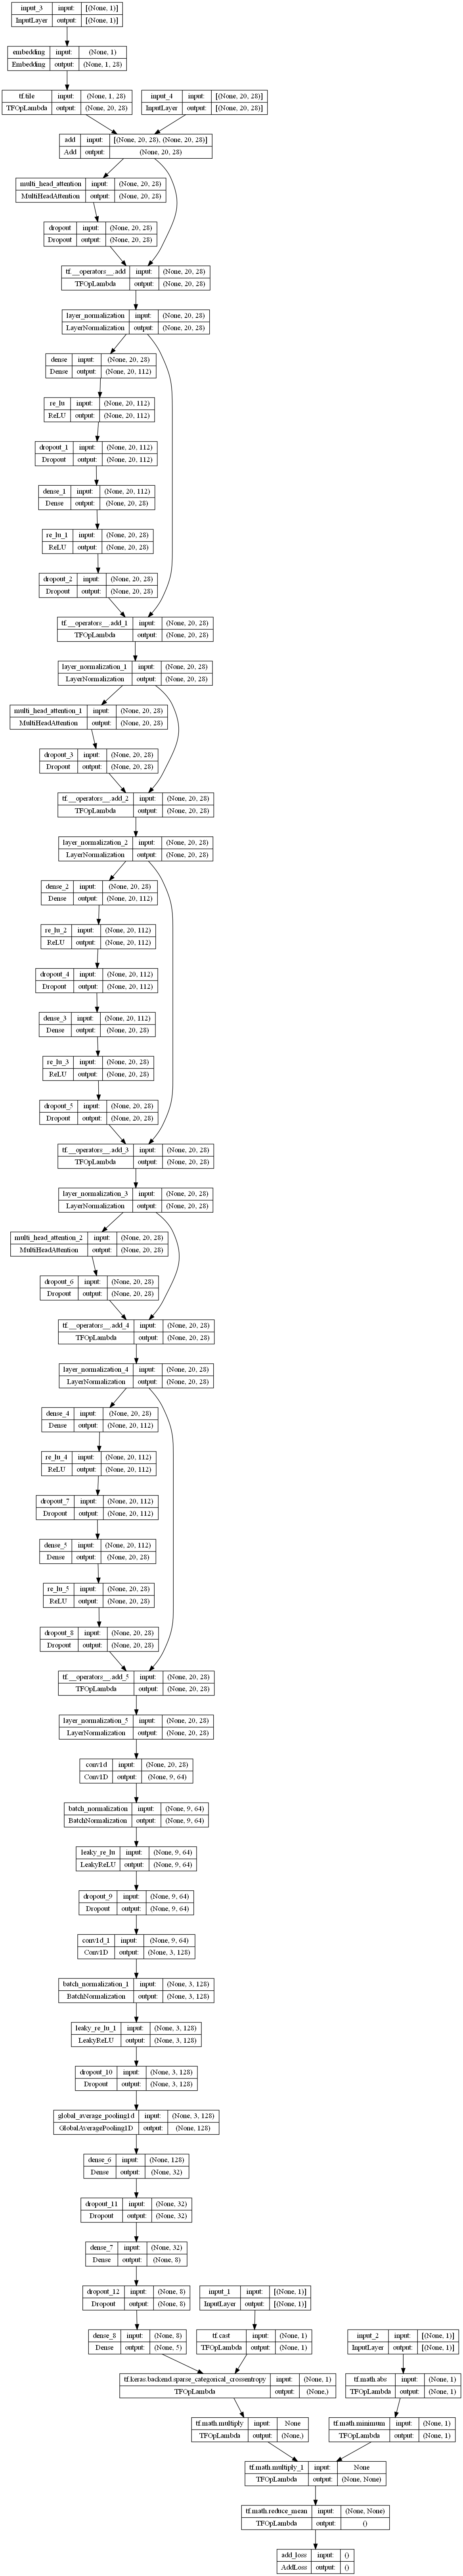

In [11]:
keras.utils.plot_model(Transformer_model.model_dict[0], "pic.png", show_shapes=True)

In [12]:
# Save previous weights to compare with next trained weights
old_weights = {}
for i in range(num_of_models):
    old_weights[i] = Transformer_model.model_dict[i].get_weights()

In [13]:
# %run C:\Projects\Stock_price_prediction\Experiments_YHdata\Transformer_Class.ipynb
gc.collect()
Transformer_model.compile_model()
Transformer_model.train_model(x_train, y_train, ret_d_train, sector_train) 
Transformer_model.evaluate_model(x_train, y_train, ret_d_train, sector_train, x_test, y_test, ret_d_test, sector_test, batch_size)

if save:
    for i in range(model_params['num_models']):
        Transformer_model.model_dict[i].save(f"models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")

gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 28)        336         ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 20, 28)]     0           []                               
                                                                                                  
 tf.tile (TFOpLambda)           (None, 20, 28)       0           ['embedding[0][0]']              
                                                                                              

 dense_4 (Dense)                (None, 20, 112)      3248        ['layer_normalization_4[0][0]']  
                                                                                                  
 re_lu_4 (ReLU)                 (None, 20, 112)      0           ['dense_4[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, 20, 112)      0           ['re_lu_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 20, 28)       3164        ['dropout_7[0][0]']              
                                                                                                  
 re_lu_5 (ReLU)                 (None, 20, 28)       0           ['dense_5[0][0]']                
                                                                                                  
 dropout_8

305/305 [==============================] - 8s 25ms/step - loss: 0.0173 - val_loss: 0.0183 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0172 - val_loss: 0.0183 - lr: 0.0050
Epoch 7/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0171 - val_loss: 0.0180 - lr: 0.0050
Epoch 8/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0170 - val_loss: 0.0180 - lr: 0.0050
Epoch 9/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0170 - val_loss: 0.0182 - lr: 0.0050
Epoch 10/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0169 - val_loss: 0.0180 - lr: 0.0050
Epoch 11/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0168 - val_loss: 0.0180 - lr: 0.0050
Epoch 12/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0168 - val_loss: 0.0180 - lr: 0.0050
Epoch 13/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0166 - val

305/305 [==============================] - 7s 25ms/step - loss: 0.0171 - val_loss: 0.0182 - lr: 0.0050
Epoch 8/500
305/305 [==============================] - 8s 26ms/step - loss: 0.0171 - val_loss: 0.0187 - lr: 0.0050
Epoch 9/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0170 - val_loss: 0.0184 - lr: 0.0050
Epoch 10/500
305/305 [==============================] - 7s 25ms/step - loss: 0.0168 - val_loss: 0.0184 - lr: 0.0025
Epoch 11/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0167 - val_loss: 0.0180 - lr: 0.0025
Epoch 12/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0167 - val_loss: 0.0180 - lr: 0.0025
Epoch 13/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0167 - val_loss: 0.0180 - lr: 0.0025
Epoch 14/500
305/305 [==============================] - 8s 26ms/step - loss: 0.0166 - val_loss: 0.0178 - lr: 0.0025
Epoch 15/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0166 - v

3190

In [14]:
# Save trained weights to compare with old weights
new_weights = {}
for i in range(num_of_models):
    y = Transformer_model.model_dict[i].predict([y_test, x_test, ret_d_test, sector_test], batch_size=4096, verbose=0)
    print(np.mean(y, axis=0))
    print(np.std(y, axis=0))
    new_weights[i] = Transformer_model.model_dict[i].get_weights()
    print(np.corrcoef(old_weights[i][0][0], new_weights[i][0][0])[0, 1])
    x = old_weights[i][-1]
    y = new_weights[i][-1]
    print(np.corrcoef(x.reshape(40, ), y.reshape(40, ))[0, 1])
    
# Now set the new weights to old weights
old_weights = new_weights.copy()

[0.06708562 0.17525111 0.48166555 0.21017049 0.06582677]
[0.06095347 0.06473458 0.19369768 0.06943442 0.06247406]
0.37622768882248875
0.6495877840383251
[0.06094736 0.17288953 0.4861854  0.2140198  0.06595805]
[0.06236524 0.0629786  0.19272192 0.06769617 0.06555714]
-0.08068365256495957
0.6543381220834965
[0.06010057 0.16674316 0.4809276  0.22308715 0.06913953]
[0.05650585 0.06268331 0.19226146 0.0730992  0.06578021]
-0.3063437862630908
0.6423749800956944


In [15]:
for i in range(num_of_models):
    y = Transformer_model.model_dict[i].predict([y_test, x_test, ret_d_test, sector_test], batch_size=4096, verbose=0)
    print(np.mean(y, axis=0))
    print(np.std(y, axis=0))

[0.06708562 0.17525111 0.48166555 0.21017049 0.06582677]
[0.06095347 0.06473458 0.19369768 0.06943442 0.06247406]
[0.06094736 0.17288953 0.4861854  0.2140198  0.06595805]
[0.06236524 0.0629786  0.19272192 0.06769617 0.06555714]
[0.06010057 0.16674316 0.4809276  0.22308715 0.06913953]
[0.05650585 0.06268331 0.19226146 0.0730992  0.06578021]


## Simulating

Testing data from 2019-07-11 to 2019-08-07 have shape (2152, 20, 28), (2152,)
top_stocks by model 0 to buy on 2019-08-08 are ['SPXL', 'TBF', 'FNDF', 'EFG', 'TECL', 'UWM', 'TBT', 'EWD', 'EFA', 'OIH']
position on 2019-08-09 market open will be {'FNDF': 0.10018997395512513, 'TBT': 0.09789675240885734, 'TBF': 0.09896959935851768, 'EFG': 0.10041942276280467, 'EFA': 0.10026975272565929, 'SPXL': 0.10288402508696011, 'TECL': 0.10284777479258994, 'OIH': 0.10024450127075744, 'UWM': 0.1025078406080747, 'EWD': 0.10003516254815066}
Total asset on 2019-08-09 will be 1.0062648055174972
It should be the same as 1.006264805517497
top_stocks by model 1 to buy on 2019-08-08 are ['DCI', 'AOR', 'FEZ', 'TNA', 'EFG', 'FNDF', 'XLV', 'PJT', 'OMFL', 'EFA']
position on 2019-08-09 market open will be {'FNDF': 0.10018997395512513, 'PJT': 0.10029947325380256, 'EFG': 0.10041942276280467, 'EFA': 0.10026975272565929, 'XLV': 0.10084098094913985, 'TNA': 0.10372917721940758, 'AOR': 0.10059892775532323, 'FEZ': 0.099862967

top_stocks by model 0 to buy on 2019-08-13 are ['AXON', 'SATS', 'CRI', 'ETN', 'CLS', 'SPR', 'SMCI', 'PCAR', 'DDS', 'OIH']
position on 2019-08-14 market open will be {'OIH': 0.09478621470050017, 'SPR': 0.09528517397207474, 'PCAR': 0.09744937034816534, 'SMCI': 0.09500211142927908, 'DDS': 0.09320576169285856, 'ETN': 0.09561558983178033, 'SATS': 0.09685068082909153, 'AXON': 0.09798662589822255, 'CRI': 0.09693392705478648, 'CLS': 0.09584310067341777}
Total asset on 2019-08-14 will be 0.9589585564301768
It should be the same as 0.9589585564301764
top_stocks by model 1 to buy on 2019-08-13 are ['SATS', 'HOUS', 'SPR', 'ETN', 'AOS', 'BC', 'DCI', 'CLS', 'PJT', 'PH']
position on 2019-08-14 market open will be {'SPR': 0.09775874888158209, 'HOUS': 0.09683543045193649, 'AOS': 0.09741532024178577, 'PJT': 0.09930115077110012, 'ETN': 0.09809774223919424, 'BC': 0.0967397322406071, 'SATS': 0.09936489583317765, 'PH': 0.09927199365484635, 'DCI': 0.098793092629549, 'CLS': 0.09833115919493166}
Total asset on

Testing data from 2019-07-19 to 2019-08-15 have shape (2152, 20, 28), (2152,)
top_stocks by model 0 to buy on 2019-08-16 are ['BK', 'EWBC', 'IEO', 'XLE', 'ROG', 'VDE', 'FENY', 'IYE', 'FXN', 'OIH']
position on 2019-08-19 market open will be {'ROG': 0.09891135412555371, 'BK': 0.09670733793584052, 'EWBC': 0.09661461372052783, 'IYE': 0.09655831371371447, 'OIH': 0.09953704055144395, 'XLE': 0.09634633433059939, 'VDE': 0.09661647159512665, 'IEO': 0.0975731207131341, 'FXN': 0.09842428367008227, 'FENY': 0.0967297530750545}
Total asset on 2019-08-19 will be 0.9740186234310777
It should be the same as 0.9740186234310774
top_stocks by model 1 to buy on 2019-08-16 are ['AIR', 'FXN', 'CBT', 'FENY', 'OIH', 'IEO', 'IYE', 'ROG', 'VDE', 'XLE']
position on 2019-08-19 market open will be {'ROG': 0.09979786155182677, 'IYE': 0.0970822624574043, 'AIR': 0.09887893737881938, 'IEO': 0.0981025760448326, 'CBT': 0.09783982216938962, 'XLE': 0.09686913282293125, 'VDE': 0.09714073591753497, 'OIH': 0.10007715258676966

top_stocks by model 0 to buy on 2019-08-21 are ['HI', 'MAN', 'CRI', 'FNB', 'EVR', 'TPR', 'TXT', 'WHR', 'AER', 'AIT']
position on 2019-08-22 market open will be {'HI': 0.09606814813581242, 'WHR': 0.09973193404604767, 'MAN': 0.09866824239941807, 'TPR': 0.10073060798691896, 'EVR': 0.09817874983477191, 'TXT': 0.09801355887639868, 'AER': 0.09756903941737709, 'AIT': 0.09818895795017678, 'CRI': 0.09863360403003285, 'FNB': 0.09915328968743872}
Total asset on 2019-08-22 will be 0.984936132364393
It should be the same as 0.9849361323643931
top_stocks by model 1 to buy on 2019-08-21 are ['NGVT', 'WHR', 'UWM', 'CFR', 'IJR', 'IEO', 'LAZ', 'SLYV', 'SLYG', 'IWO']
position on 2019-08-22 market open will be {'WHR': 0.10097581870509527, 'SLYG': 0.09971954367408663, 'SLYV': 0.09970403343831967, 'LAZ': 0.09927709827457375, 'IWO': 0.09982499105285722, 'IJR': 0.0993417277701259, 'IEO': 0.09983430224667686, 'UWM': 0.09966872647436752, 'CFR': 0.09952449009236475, 'NGVT': 0.1023639312099113}
Total asset on 201

top_stocks by model 0 to buy on 2019-08-26 are ['ROG', 'CLS', 'AGNC', 'TS', 'OIH', 'HI', 'HUN', 'MMM', 'TBT', 'DXC']
position on 2019-08-27 market open will be {'DXC': 0.09627400451676549, 'CLS': 0.09358146258320316, 'TBT': 0.09638322083423613, 'HUN': 0.09732614284424546, 'ROG': 0.09957231177375177, 'AGNC': 0.09707754501289136, 'OIH': 0.09732614284424546, 'MMM': 0.0975245051786735, 'HI': 0.09754306396520895, 'TS': 0.09763666244915342}
Total asset on 2019-08-27 will be 0.9702450620023746
It should be the same as 0.9702450620023746
top_stocks by model 1 to buy on 2019-08-26 are ['FMS', 'CXW', 'TXRH', 'BMO', 'ROK', 'CLS', 'PFE', 'SRLN', 'TBT', 'MMM']
position on 2019-08-27 market open will be {'MMM': 0.09600465691071039, 'CLS': 0.09333484783607984, 'ROK': 0.09533466175355497, 'TXRH': 0.10111329751069906, 'PFE': 0.09831039323858676, 'TBT': 0.09627339154713803, 'CXW': 0.0999812893548269, 'BMO': 0.09547303050570848, 'SRLN': 0.09736349697485684, 'FMS': 0.09695522762188026}
Total asset on 2019

top_stocks by model 0 to buy on 2019-08-29 are ['CFR', 'USB', 'BAC', 'MLI', 'TMV', 'PLCE', 'IBM', 'ILF', 'TBF', 'TBT']
position on 2019-08-30 market open will be {'IBM': 0.09910010403026068, 'TMV': 0.09949088652725467, 'TBT': 0.0990453551419236, 'PLCE': 0.09775267183617632, 'BAC': 0.09989303838112357, 'MLI': 0.09882462577382005, 'TBF': 0.09850438368802984, 'ILF': 0.10072305947496654, 'USB': 0.09931875594804819, 'CFR': 0.09881836090738227}
Total asset on 2019-08-30 will be 0.9914712417089854
It should be the same as 0.9914712417089856
top_stocks by model 1 to buy on 2019-08-29 are ['FUL', 'ILF', 'DELL', 'KBWB', 'FITB', 'PLCE', 'BAC', 'IYG', 'IBM', 'USB']
position on 2019-08-30 market open will be {'IBM': 0.10011939304075113, 'ILF': 0.09989980712908102, 'PLCE': 0.09839338397945806, 'BAC': 0.10054777938735772, 'IYG': 0.09993013815923667, 'KBWB': 0.10034242394712978, 'FUL': 0.10119895487755542, 'USB': 0.09996973286557118, 'FITB': 0.10096067688059165, 'DELL': 0.10972444940365038}
Total asse

top_stocks by model 0 to buy on 2019-09-04 are ['SCHH', 'KMX', 'BOKF', 'PCG', 'IBKR', 'NTES', 'SSB', 'QRTEA', 'ECH', 'AGNC']
position on 2019-09-05 market open will be {'AGNC': 0.10003442599649949, 'ECH': 0.09822670309988707, 'SCHH': 0.09863785472941614, 'NTES': 0.10159966872807931, 'QRTEA': 0.10317548028192883, 'PCG': 0.09838553246871617, 'BOKF': 0.09985574022155962, 'KMX': 0.1016138118408943, 'IBKR': 0.09929593993832449, 'SSB': 0.0983586299601757}
Total asset on 2019-09-05 will be 0.9991837872654808
It should be the same as 0.9991837872654813
top_stocks by model 1 to buy on 2019-09-04 are ['ERJ', 'AVNT', 'SSB', 'AGNC', 'DGX', 'PDI', 'WEX', 'IBKR', 'GPRE', 'CI']
position on 2019-09-05 market open will be {'ERJ': 0.10321614658176811, 'GPRE': 0.10564243720218996, 'CI': 0.10047014722779349, 'DGX': 0.10220497146137981, 'PDI': 0.10234096056898369, 'AGNC': 0.10319899427119562, 'AVNT': 0.10277207294934838, 'WEX': 0.10350828929832233, 'IBKR': 0.10241456518620543, 'SSB': 0.10144781675805797}
T

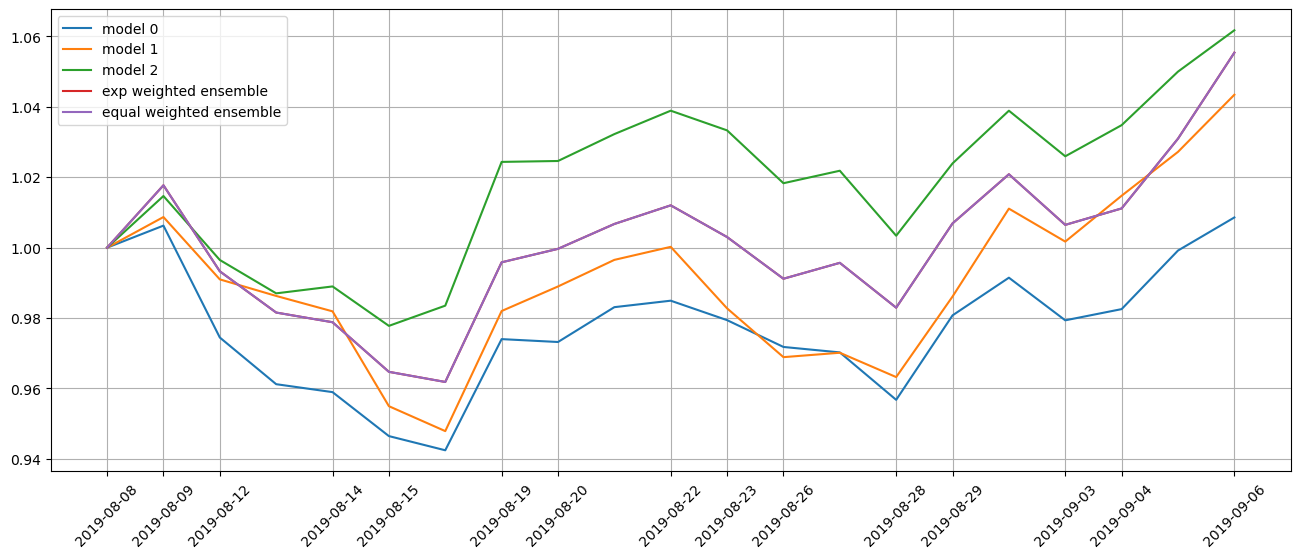

In [16]:
# %run C:\Projects\Stock_price_prediction\Experiments_YHdata\simulation_functions.ipynb
# ftd = 100
# ltd = 199
first_run = True
total_dict = {}
total_asset_dict = {}
position_dict_all = {}
num_iter = 0
for i in range(num_of_models):
    total_dict[i] = 1
    total_asset_dict[i] = [1]
    position_dict_all[i] = {}
total_dict['ensemble_weighted'] = 1
total_asset_dict['ensemble_weighted'] = [1]
position_dict_all['ensemble_weighted'] = {}
total_dict['ensemble_equal'] = 1
total_asset_dict['ensemble_equal'] = [1]
position_dict_all['ensemble_equal'] = {}

return_dict = {}
total_asset_dict, total_dict, position_dict_all, return_dict = simulate(ftd, ltd, total_dict, first_run, num_stocks, total_asset_dict, position_dict_all, return_dict)

In [17]:
pd.DataFrame(Transformer_model.model_dict[0].predict([y_test, x_test, ret_d_test, sector_test], batch_size=4096, verbose=0)).to_csv('test0.csv')
pd.DataFrame(Transformer_model.model_dict[1].predict([y_test, x_test, ret_d_test, sector_test], batch_size=4096, verbose=0)).to_csv('test1.csv')
pd.DataFrame(Transformer_model.model_dict[2].predict([y_test, x_test, ret_d_test, sector_test], batch_size=4096, verbose=0)).to_csv('test2.csv')

# Retraining

Running 67 iterations; first iteration already completed.
Standardization data are from 2018-02-01 to 2018-11-14
Training data are from 2018-11-15 to 2019-09-04
Testing data are from 2019-08-08 to 2019-10-02
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 2 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 9s 28ms/step - loss: 0.0156 - val_loss: 0.0206 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 8s 26ms/step - loss: 0.0155 - val_loss: 0.0204 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0155 - val_loss: 0.0210 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0154 - val_loss: 0.0206 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0154 - val_loss: 0.0207 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 8s 25ms/step - los

Epoch 22/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0149 - val_loss: 0.0214 - lr: 6.2500e-04
Epoch 23/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0148 - val_loss: 0.0212 - lr: 6.2500e-04
Epoch 24/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0148 - val_loss: 0.0211 - lr: 6.2500e-04
Epoch 24: early stopping
96/96 [==============================] - 2s 24ms/step
Model 0 training loss 0.023008113726973534
11/11 [==============================] - 0s 23ms/step
Model 0 test loss 0.026786770671606064
96/96 [==============================] - 2s 24ms/step
Model 1 training loss 0.023153353482484818
11/11 [==============================] - 0s 23ms/step
Model 1 test loss 0.0271471980959177
96/96 [==============================] - 2s 24ms/step
Model 2 training loss 0.023913420736789703
11/11 [==============================] - 0s 23ms/step
Model 2 test loss 0.027761485427618027
Correlations between old and new weights
0.9752

position on 2019-09-11 market open will be {'AGNC': 0.10741978717681738, 'MAT': 0.11535773671106356, 'ODP': 0.12451386549534976, 'TDC': 0.11320525421091818, 'IAG': 0.11198826160668482, 'JBLU': 0.10880661886002059, 'IAU': 0.10926711245683883, 'OKTA': 0.11036436396167842, 'HL': 0.12268268165097426, 'RAMP': 0.11425790126667713}
Total asset on 2019-09-11 will be 1.1378635833970232
It should be the same as 1.137863583397023
Testing data from 2019-08-13 to 2019-09-10 have shape (2152, 20, 28), (2152,)
top_stocks by model 0 to buy on 2019-09-11 are ['REM', 'YEXT', 'KOLD', 'RHI', 'TTD', 'SBH', 'PCG', 'BBWI', 'AGNC', 'NLY']
position on 2019-09-12 market open will be {'AGNC': 0.10538028828439214, 'PCG': 0.10184903244731094, 'TTD': 0.1082840099227189, 'RHI': 0.10945151475043374, 'BBWI': 0.10807799169230695, 'REM': 0.10943843676080821, 'SBH': 0.11289808963544926, 'KOLD': 0.10973824796181401, 'YEXT': 0.11323168975441239, 'NLY': 0.10967259691110959}
Total asset on 2019-09-12 will be 1.08802189812075

top_stocks by model 0 to buy on 2019-09-16 are ['TEAM', 'MVIS', 'NEO', 'CYBR', 'SCHO', 'AZUL', 'TTD', 'ODP', 'OKTA', 'IAG']
position on 2019-09-17 market open will be {'TEAM': 0.11218556030305486, 'IAG': 0.10912519532356989, 'NEO': 0.10998514841840354, 'AZUL': 0.10527525497758726, 'OKTA': 0.11116576505909766, 'SCHO': 0.10819664891611297, 'ODP': 0.11009663211122986, 'CYBR': 0.11088684322417228, 'TTD': 0.11155921186449376, 'MVIS': 0.11148157003081761}
Total asset on 2019-09-17 will be 1.0999578302285387
It should be the same as 1.0999578302285398
top_stocks by model 1 to buy on 2019-09-16 are ['SRLN', 'LPSN', 'MGNX', 'AZPN', 'IQLT', 'OKTA', 'SBSW', 'IAG', 'TWLO', 'CYBR']
position on 2019-09-17 market open will be {'TWLO': 0.1124755537195399, 'OKTA': 0.1065960473526301, 'LPSN': 0.10739045892524685, 'MGNX': 0.11157551362494823, 'SBSW': 0.11270940898505159, 'IAG': 0.1101229868581805, 'AZPN': 0.1141143184174091, 'IQLT': 0.10895947349951006, 'SRLN': 0.1091662283176072, 'CYBR': 0.1119007424721

top_stocks by model 0 to buy on 2019-09-19 are ['ADNT', 'SCO', 'GIII', 'HUM', 'KOLD', 'EVH', 'EVTC', 'ODP', 'MAT', 'VCLT']
position on 2019-09-20 market open will be {'HUM': 0.11042347631945745, 'VCLT': 0.11152913500917393, 'KOLD': 0.11770585753574017, 'EVH': 0.10939289228214223, 'GIII': 0.10923199012540233, 'SCO': 0.1105296677400653, 'MAT': 0.11066054372241924, 'ODP': 0.10678859815793562, 'EVTC': 0.10870887577698432, 'ADNT': 0.10902098914476302}
Total asset on 2019-09-20 will be 1.103992025814082
It should be the same as 1.1039920258140836
top_stocks by model 1 to buy on 2019-09-19 are ['VCLT', 'CAKE', 'EVTC', 'SKT', 'RRX', 'FOXF', 'MGNX', 'NSP', 'MAT', 'DELL']
position on 2019-09-20 market open will be {'MGNX': 0.10880709930497352, 'RRX': 0.10922378707427129, 'DELL': 0.10953077476445629, 'FOXF': 0.10780236541452183, 'VCLT': 0.11185134472035584, 'CAKE': 0.10857534236763282, 'NSP': 0.11105813829309583, 'SKT': 0.11102551028794158, 'MAT': 0.1120206316204261, 'EVTC': 0.11004497644463586}


top_stocks by model 0 to buy on 2019-09-24 are ['ODP', 'RL', 'SLYV', 'SPMD', 'TTD', 'UWM', 'HUM', 'RHI', 'XRT', 'KOLD']
position on 2019-09-25 market open will be {'RHI': 0.11086354677907173, 'HUM': 0.11117987159693035, 'TTD': 0.10357599741882913, 'SLYV': 0.11173087656904136, 'RL': 0.1105424132370811, 'ODP': 0.11111612403345866, 'SPMD': 0.11148478560640396, 'UWM': 0.10867750590031976, 'KOLD': 0.12126736569862911, 'XRT': 0.11170026338148342}
Total asset on 2019-09-25 will be 1.1121387502212468
It should be the same as 1.1121387502212485
top_stocks by model 1 to buy on 2019-09-24 are ['MGNX', 'SPSC', 'RHI', 'IJR', 'SPMD', 'MO', 'CHKP', 'RL', 'SLYV', 'DELL']
position on 2019-09-25 market open will be {'MGNX': 0.1107155873229866, 'SPSC': 0.10621945704099264, 'RHI': 0.10869257516673055, 'CHKP': 0.10762406113109164, 'SLYV': 0.10854523876209896, 'RL': 0.10739066054622044, 'MO': 0.111278878483858, 'SPMD': 0.10830616427242407, 'IJR': 0.10809434133105446, 'DELL': 0.10810854024915108}
Total asset

top_stocks by model 0 to buy on 2019-09-27 are ['APPF', 'PLNT', 'VEEV', 'QRTEA', 'OKTA', 'TDW', 'BL', 'GBTC', 'TTD', 'KOLD']
position on 2019-09-30 market open will be {'KOLD': 0.13543845632624668, 'APPF': 0.10866232435897163, 'TDW': 0.10848089412234747, 'BL': 0.1088097343734817, 'QRTEA': 0.10973652966115106, 'PLNT': 0.10647193566850996, 'OKTA': 0.10397443709842333, 'VEEV': 0.10613484889576573, 'GBTC': 0.11056001936564146, 'TTD': 0.10456361416858072}
Total asset on 2019-09-30 will be 1.1028327940391178
It should be the same as 1.1028327940391198
top_stocks by model 1 to buy on 2019-09-27 are ['SEDG', 'MGNX', 'KOLD', 'WIX', 'SPSC', 'NEO', 'TBT', 'TTD', 'LPSN', 'DVA']
position on 2019-09-30 market open will be {'TBT': 0.10975498564968829, 'MGNX': 0.1105168426920371, 'DVA': 0.10986759337787394, 'NEO': 0.1061749293509231, 'WIX': 0.10773435495059823, 'TTD': 0.10436460350390256, 'SEDG': 0.10554414980880564, 'LPSN': 0.10700241646832373, 'KOLD': 0.11373076547020061, 'SPSC': 0.10694711143020595

top_stocks by model 0 to buy on 2019-10-02 are ['TAN', 'HUM', 'EVH', 'GDX', 'FN', 'BOIL', 'GNRC', 'JNUG', 'BTU', 'DELL']
position on 2019-10-03 market open will be {'DELL': 0.11227994819027193, 'TAN': 0.10880826235558558, 'EVH': 0.10526782450865071, 'GDX': 0.10887355757453213, 'BTU': 0.11057905471198139, 'HUM': 0.10981316274230679, 'BOIL': 0.10515854882268537, 'GNRC': 0.10971733138383137, 'FN': 0.1084486457270221, 'JNUG': 0.10754601199220346}
Total asset on 2019-10-03 will be 1.0864923480090694
It should be the same as 1.0864923480090707
top_stocks by model 1 to buy on 2019-10-02 are ['OUNZ', 'CSIQ', 'MGNX', 'NEM', 'SLV', 'FN', 'SEDG', 'SIVR', 'SIL', 'DELL']
position on 2019-10-03 market open will be {'MGNX': 0.10201000721821592, 'DELL': 0.1066306123076672, 'OUNZ': 0.1073604591729621, 'SIL': 0.10613818610446772, 'SLV': 0.10717566672107219, 'CSIQ': 0.10455260263033377, 'FN': 0.1061990433875531, 'SEDG': 0.10521526082262461, 'SIVR': 0.10729029930581846, 'NEM': 0.106960638282571}
Total ass

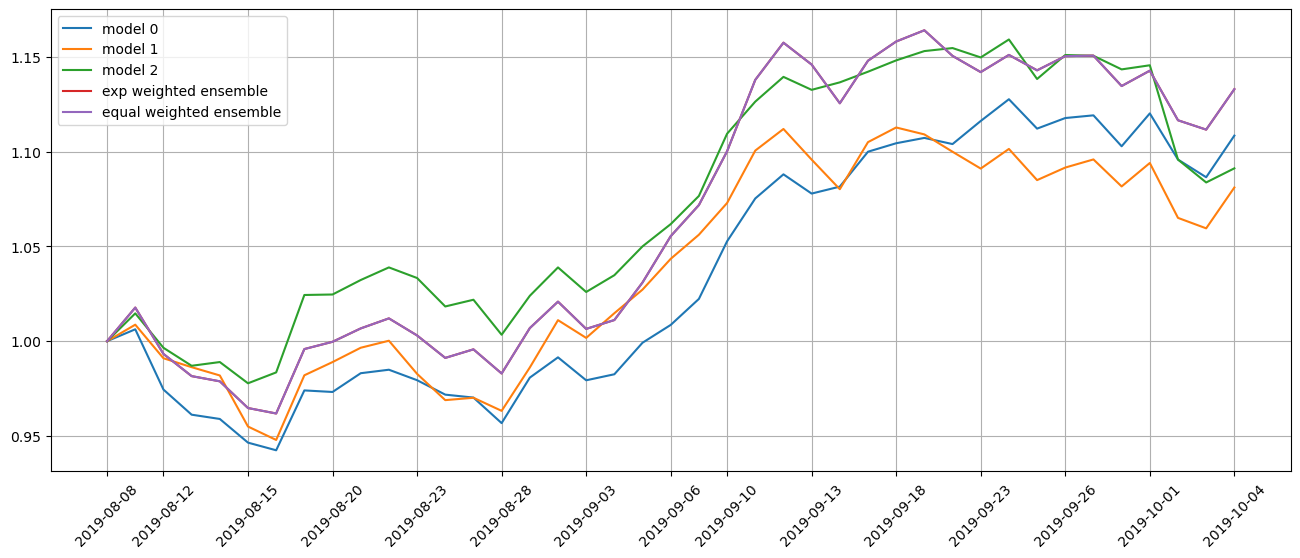

Standardization data are from 2018-03-02 to 2018-12-14
Training data are from 2018-12-17 to 2019-10-02
Testing data are from 2019-09-06 to 2019-10-30
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 3 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0152 - val_loss: 0.0201 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 24ms/step - loss: 0.0151 - val_loss: 0.0198 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0151 - val_loss: 0.0201 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0151 - val_loss: 0.0197 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0197 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0199 - lr: 0.0050
Epoch 7/500
305/

305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0201 - lr: 0.0012
Epoch 21/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0200 - lr: 0.0012
Epoch 22/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0201 - lr: 0.0012
Epoch 23/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0199 - lr: 6.2500e-04
Epoch 24/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0200 - lr: 6.2500e-04
Epoch 25/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0199 - lr: 6.2500e-04
Epoch 26/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0145 - val_loss: 0.0200 - lr: 6.2500e-04
Epoch 27/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0144 - val_loss: 0.0200 - lr: 6.2500e-04
Epoch 27: early stopping
96/96 [==============================] -

top_stocks by model 1 to buy on 2019-10-08 are ['FSS', 'DBO', 'EWZ', 'SAIC', 'ALTR', 'UCO', 'XRT', 'MRCY', 'AVT', 'USO']
position on 2019-10-09 market open will be {'FSS': 0.10629606838607623, 'DBO': 0.11077718121073384, 'ALTR': 0.10892237450128264, 'AVT': 0.1077253494134334, 'MRCY': 0.10821749758197098, 'SAIC': 0.10771757977950587, 'EWZ': 0.10791285660390018, 'USO': 0.11090942047458678, 'UCO': 0.11369230157292586, 'XRT': 0.10822871570882313}
Total asset on 2019-10-09 will be 1.0903993452332372
It should be the same as 1.0903993452332388
top_stocks by model 2 to buy on 2019-10-08 are ['UPBD', 'KAR', 'USO', 'WEX', 'YEXT', 'MRCY', 'ADSK', 'ENSG', 'DBO', 'FN']
position on 2019-10-09 market open will be {'FN': 0.10578644717912584, 'YEXT': 0.1069780510346178, 'DBO': 0.11146764594562768, 'KAR': 0.11021463114388214, 'MRCY': 0.10889200802683117, 'ENSG': 0.10856186251968016, 'USO': 0.11160070944554856, 'WEX': 0.10793034073424729, 'ADSK': 0.10935991645453146, 'UPBD': 0.11041655553901135}
Total a

top_stocks by model 2 to buy on 2019-10-11 are ['WAT', 'FIVE', 'BCS', 'TRI', 'CYRX', 'BURL', 'WOLF', 'QDEL', 'CI', 'DELL']
position on 2019-10-14 market open will be {'CYRX': 0.11624842759378434, 'BCS': 0.11021972711926968, 'WOLF': 0.10906031002120149, 'FIVE': 0.11290407881038801, 'BURL': 0.11216564191362421, 'WAT': 0.11075282543961712, 'CI': 0.11151851560061281, 'QDEL': 0.11141109342919343, 'TRI': 0.1099278767588279, 'DELL': 0.11261186878213697}
Total asset on 2019-10-14 will be 1.1168203654686528
It should be the same as 1.116820365468656
top_stocks by return weighted ensemble to buy on 2019-10-11 are ['WAT', 'MNRO', 'FIVE', 'ON', 'DECK', 'MUR', 'EXPD', 'CYRX', 'BURL', 'DELL']
position on 2019-10-14 market open will be {'CYRX': 0.12070189294743083, 'FIVE': 0.1176717710052227, 'DECK': 0.11829556525969091, 'ON': 0.11698610944111058, 'BURL': 0.11690215153413411, 'WAT': 0.11542967491191244, 'EXPD': 0.11760900140296478, 'MUR': 0.11571721521315517, 'MNRO': 0.11671788174331796, 'DELL': 0.11

top_stocks by model 2 to buy on 2019-10-16 are ['ACN', 'AZPN', 'NTCT', 'TRI', 'SONY', 'MMS', 'STIP', 'BWX', 'INFY', 'WOLF']
position on 2019-10-17 market open will be {'WOLF': 0.11306967372937436, 'STIP': 0.11276307117120538, 'BWX': 0.11308288055833184, 'MMS': 0.11331674036100967, 'AZPN': 0.10940275183338, 'NTCT': 0.1140374447473284, 'TRI': 0.11306647625890102, 'ACN': 0.1141041933660955, 'SONY': 0.11560417533652761, 'INFY': 0.11202483124192489}
Total asset on 2019-10-17 will be 1.1304722386040749
It should be the same as 1.1304722386040786
top_stocks by return weighted ensemble to buy on 2019-10-16 are ['TRI', 'EEFT', 'VGSH', 'SCHO', 'STX', 'WOLF', 'STIP', 'NTCT', 'INFY', 'BWX']
position on 2019-10-17 market open will be {'VGSH': 0.117359113921281, 'SCHO': 0.11743471184583848, 'BWX': 0.11777980755931243, 'WOLF': 0.11246221189977522, 'STIP': 0.1173205738625571, 'EEFT': 0.11768252953508059, 'NTCT': 0.1186623991472027, 'TRI': 0.11765205161978826, 'STX': 0.11733331110935147, 'INFY': 0.1165

top_stocks by model 2 to buy on 2019-10-21 are ['SPSC', 'DQ', 'JACK', 'HEI', 'INFY', 'HAE', 'BNDX', 'YUM', 'WIX', 'NTCT']
position on 2019-10-22 market open will be {'BNDX': 0.11291618769158379, 'WIX': 0.10899495523859522, 'HEI': 0.11269389805577293, 'JACK': 0.11156882659186386, 'DQ': 0.11317928717560827, 'NTCT': 0.11201113033211202, 'YUM': 0.11255187262011779, 'HAE': 0.11244445001862388, 'SPSC': 0.11486719048192304, 'INFY': 0.11451505410516506}
Total asset on 2019-10-22 will be 1.1257428523113622
It should be the same as 1.125742852311366
top_stocks by return weighted ensemble to buy on 2019-10-21 are ['HEI', 'MRK', 'CME', 'ORCL', 'DQ', 'INFY', 'WIX', 'NTCT', 'DBO', 'USO']
position on 2019-10-22 market open will be {'WIX': 0.11302622907833502, 'HEI': 0.11754298023737461, 'DBO': 0.12063510574170438, 'DQ': 0.11804925506418026, 'ORCL': 0.1183335744356297, 'CME': 0.1146657623710948, 'NTCT': 0.11683083384405991, 'USO': 0.1207669573655562, 'INFY': 0.1194424984297166, 'MRK': 0.11386651420553

top_stocks by model 2 to buy on 2019-10-24 are ['RPD', 'FIVN', 'PRO', 'CNH', 'JBHT', 'SWKS', 'OKTA', 'IGV', 'ADSK', 'VLUE']
position on 2019-10-25 market open will be {'VLUE': 0.11439211789369817, 'FIVN': 0.11737866636027208, 'RPD': 0.11784699184218797, 'CNH': 0.11425674504802644, 'IGV': 0.11610398552143146, 'JBHT': 0.11407858262102773, 'OKTA': 0.12000328701179047, 'PRO': 0.104238869959191, 'SWKS': 0.11451729284530894, 'ADSK': 0.11647698247545168}
Total asset on 2019-10-25 will be 1.1492935215783822
It should be the same as 1.1492935215783857
top_stocks by return weighted ensemble to buy on 2019-10-24 are ['JBHT', 'IWO', 'CCOI', 'VOX', 'JBT', 'VLUE', 'ADSK', 'SWKS', 'ARKQ', 'IGV']
position on 2019-10-25 market open will be {'VLUE': 0.11644004055219066, 'IGV': 0.11818255515602447, 'CCOI': 0.1156827795376565, 'VOX': 0.11628262561445771, 'JBHT': 0.11612089216560152, 'IWO': 0.11638325679253282, 'SWKS': 0.11656745646781538, 'ARKQ': 0.1166591869071144, 'ADSK': 0.11856222974594961, 'JBT': 0.1

top_stocks by model 2 to buy on 2019-10-29 are ['MMS', 'DRI', 'AAON', 'ACN', 'EVTC', 'IHI', 'VRSK', 'HIG', 'SAIC', 'ARI']
position on 2019-10-30 market open will be {'MMS': 0.11779529731383073, 'SAIC': 0.1210239217978557, 'HIG': 0.1173924636964351, 'VRSK': 0.11563072649696796, 'AAON': 0.11777340139366624, 'ACN': 0.11856135556921996, 'DRI': 0.11706163498128536, 'ARI': 0.11689644361037489, 'EVTC': 0.1177658237266059, 'IHI': 0.11780113820295397}
Total asset on 2019-10-30 will be 1.1777022067891922
It should be the same as 1.1777022067891958
top_stocks by return weighted ensemble to buy on 2019-10-29 are ['HIG', 'ARKG', 'BOH', 'CRS', 'JKHY', 'VRNS', 'AIG', 'ONB', 'SAIC', 'IHI']
position on 2019-10-30 market open will be {'JKHY': 0.11794893079900315, 'ARKG': 0.1213990977817271, 'SAIC': 0.12074251440727533, 'ONB': 0.11636019368920929, 'HIG': 0.11646869677134945, 'VRNS': 0.11779129236577339, 'AIG': 0.11562211502719583, 'CRS': 0.11568002050448427, 'BOH': 0.11832336313455373, 'IHI': 0.116874155

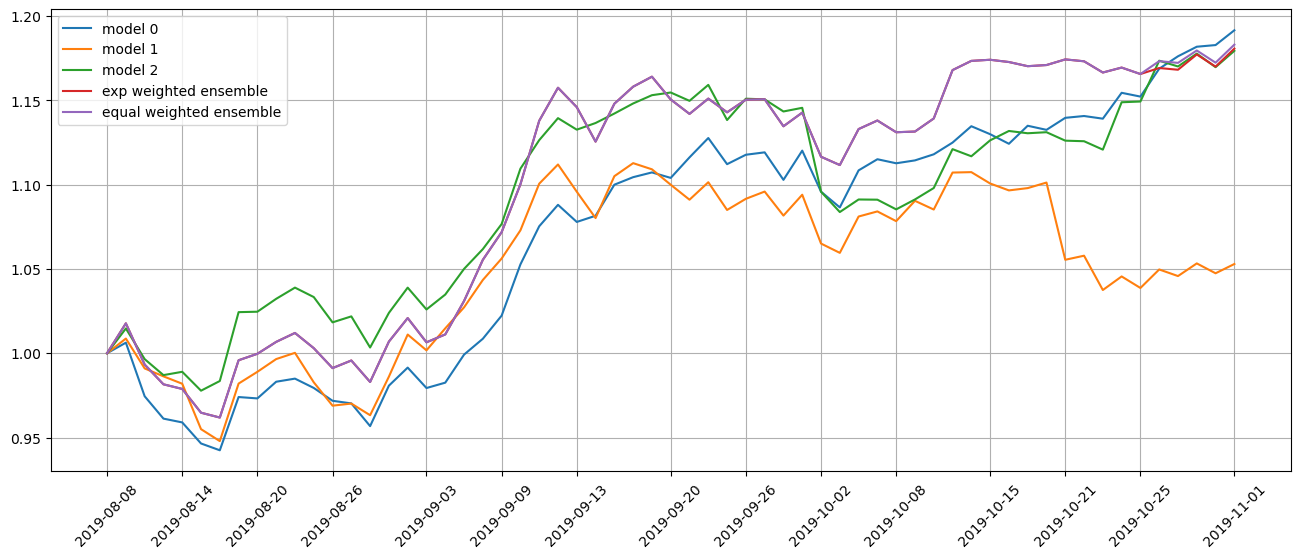

Standardization data are from 2018-04-02 to 2019-01-15
Training data are from 2019-01-16 to 2019-10-30
Testing data are from 2019-10-04 to 2019-11-27
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 4 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0156 - val_loss: 0.0163 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0156 - val_loss: 0.0161 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0162 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0163 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0154 - val_loss: 0.0163 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0154 - val_loss: 0.0162 - lr: 0.0050
Epoch 7/500
305/

Epoch 37/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0149 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 38/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0149 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 39/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0148 - val_loss: 0.0163 - lr: 5.0000e-04
Epoch 40/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0149 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 41/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0149 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 42/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0148 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 43/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0148 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 44/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0148 - val_loss: 0.0162 - lr: 5.0000e-04
Epoch 45/500
305/305 [==================

top_stocks by model 1 to buy on 2019-11-04 are ['NVCR', 'MU', 'TER', 'CHE', 'DD', 'ABG', 'EXPD', 'AIG', 'CXW', 'ECH']
position on 2019-11-05 market open will be {'CXW': 0.11050800417399959, 'CHE': 0.10697455727511257, 'NVCR': 0.11062876236203145, 'TER': 0.10674825563537652, 'DD': 0.11004609110748703, 'AIG': 0.10887788379654659, 'MU': 0.10712669008761122, 'EXPD': 0.10943203788167717, 'ECH': 0.10414684335040547, 'ABG': 0.10715167230466699}
Total asset on 2019-11-05 will be 1.0816407979749114
It should be the same as 1.0816407979749147
top_stocks by model 2 to buy on 2019-11-04 are ['SGOL', 'TER', 'UPBD', 'SKYY', 'FUN', 'DBA', 'LOPE', 'DRIP', 'CXW', 'ECH']
position on 2019-11-05 market open will be {'FUN': 0.11551217598805164, 'CXW': 0.12377877297812649, 'SGOL': 0.11940796936188272, 'TER': 0.12012013315003033, 'LOPE': 0.12037912108523786, 'SKYY': 0.11959623855779439, 'ECH': 0.11719285355947474, 'DBA': 0.12013654958120322, 'DRIP': 0.10630631655337408, 'UPBD': 0.11530317315273887}
Total ass

top_stocks by model 2 to buy on 2019-11-07 are ['EGHT', 'UPBD', 'IRT', 'IYH', 'IHI', 'IYZ', 'GPRO', 'FHLC', 'IBKR', 'XLV']
position on 2019-11-08 market open will be {'IBKR': 0.11815484519780277, 'IYZ': 0.1189564449869632, 'EGHT': 0.11507996513208807, 'GPRO': 0.1276995987935915, 'XLV': 0.11781989888611777, 'FHLC': 0.11800428497068037, 'IYH': 0.11792724332692163, 'IRT': 0.1172665734949499, 'IHI': 0.11771067337748861, 'UPBD': 0.11398909110371186}
Total asset on 2019-11-08 will be 1.1826086192703125
It should be the same as 1.1826086192703156
top_stocks by return weighted ensemble to buy on 2019-11-07 are ['SBUX', 'CXW', 'USO', 'IBKR', 'XLV', 'ICF', 'IRT', 'LTC', 'IHI', 'GPRO']
position on 2019-11-08 market open will be {'IBKR': 0.12160700269566305, 'GPRO': 0.13181177807996722, 'XLV': 0.12161393232318046, 'CXW': 0.12312036484431196, 'SBUX': 0.12060787315401943, 'USO': 0.11934102768619358, 'ICF': 0.12060572441947874, 'IRT': 0.12104278876160578, 'IHI': 0.12150118953745434, 'LTC': 0.11909366

top_stocks by model 2 to buy on 2019-11-12 are ['MVIS', 'SLV', 'DRIP', 'FUN', 'AGQ', 'BFAM', 'PPLT', 'SGOL', 'HYD', 'CEF']
position on 2019-11-13 market open will be {'SGOL': 0.11974232954736977, 'PPLT': 0.11906245892107917, 'SLV': 0.1200489556514366, 'MVIS': 0.11423559755368576, 'BFAM': 0.11997743676543338, 'HYD': 0.11924878230031088, 'DRIP': 0.12520212198963943, 'FUN': 0.12047509621066371, 'CEF': 0.11974476462336525, 'AGQ': 0.12066118198758677}
Total asset on 2019-11-13 will be 1.1983987255505668
It should be the same as 1.1983987255505706
top_stocks by return weighted ensemble to buy on 2019-11-12 are ['BFAM', 'CNK', 'MUB', 'HTGC', 'GFF', 'CEF', 'AYI', 'FUN', 'HASI', 'HYD']
position on 2019-11-13 market open will be {'CEF': 0.12392487765075864, 'HASI': 0.11959834107000798, 'CNK': 0.12092104120362633, 'HTGC': 0.12428404445696403, 'MUB': 0.12343644039574184, 'AYI': 0.12104328135920063, 'BFAM': 0.12416567203395547, 'HYD': 0.12341158131672035, 'FUN': 0.12468070403602999, 'GFF': 0.123275

top_stocks by model 2 to buy on 2019-11-15 are ['GNRC', 'UAL', 'SAVE', 'MATX', 'AER', 'IJH', 'HEDJ', 'RHI', 'BURL', 'IRDM']
position on 2019-11-18 market open will be {'RHI': 0.12026452468138385, 'HEDJ': 0.12064001232268884, 'BURL': 0.12284262336111079, 'MATX': 0.11928357523696317, 'GNRC': 0.11970324906220334, 'IJH': 0.12071712357472188, 'AER': 0.11929246915775445, 'UAL': 0.12033967970693413, 'IRDM': 0.12130551799288285, 'SAVE': 0.12169374872561184}
Total asset on 2019-11-18 will be 1.2060825238222512
It should be the same as 1.2060825238222552
top_stocks by return weighted ensemble to buy on 2019-11-15 are ['ASML', 'SNBR', 'SGH', 'UAL', 'CTAS', 'MGNI', 'HEDJ', 'IRDM', 'RHI', 'BURL']
position on 2019-11-18 market open will be {'RHI': 0.12764805927286682, 'CTAS': 0.12689682893651055, 'HEDJ': 0.12804659964726658, 'BURL': 0.1303844380508393, 'IRDM': 0.12875296345205783, 'UAL': 0.1277278283750315, 'MGNI': 0.11666369105042951, 'SGH': 0.12941381435567834, 'ASML': 0.1279068906132328, 'SNBR': 

top_stocks by model 2 to buy on 2019-11-20 are ['AOS', 'EWP', 'BBVA', 'BCO', 'BDX', 'FCFS', 'GBTC', 'SAVE', 'ECH', 'HSBC']
position on 2019-11-21 market open will be {'AOS': 0.12063085410404077, 'BCO': 0.12011372249330957, 'FCFS': 0.1206861813631417, 'BBVA': 0.12196666823790887, 'HSBC': 0.11941313430960154, 'ECH': 0.12031838006415034, 'BDX': 0.12078107587667578, 'GBTC': 0.11882949789132402, 'EWP': 0.12088094446216212, 'SAVE': 0.1197021298568382}
Total asset on 2019-11-21 will be 1.203322588659149
It should be the same as 1.2033225886591528
top_stocks by return weighted ensemble to buy on 2019-11-20 are ['CF', 'BCO', 'KW', 'TRI', 'SAVE', 'YEXT', 'EWP', 'AGI', 'GBTC', 'HSBC']
position on 2019-11-21 market open will be {'CF': 0.12337213587981312, 'BCO': 0.12406557632371132, 'KW': 0.12449316717284233, 'HSBC': 0.12334193813339416, 'TRI': 0.12512563925350148, 'AGI': 0.12522111652267745, 'GBTC': 0.12273909953099266, 'EWP': 0.12485804061303685, 'YEXT': 0.12593261321637775, 'SAVE': 0.1236404419

top_stocks by model 2 to buy on 2019-11-25 are ['EMN', 'NVMI', 'JBLU', 'JBT', 'TBT', 'CNI', 'ECH', 'JBHT', 'FAST', 'SKT']
position on 2019-11-26 market open will be {'NVMI': 0.12465929739005494, 'TBT': 0.12050638464800496, 'FAST': 0.12420233433843958, 'EMN': 0.12548201973070544, 'JBLU': 0.12505850397035892, 'CNI': 0.12430012413552108, 'JBHT': 0.12494220638651272, 'SKT': 0.12391592335914531, 'ECH': 0.12125341420586787, 'JBT': 0.1261079667682046}
Total asset on 2019-11-26 will be 1.2404281749328108
It should be the same as 1.2404281749328154
top_stocks by return weighted ensemble to buy on 2019-11-25 are ['DLTR', 'SAVE', 'CRS', 'MMM', 'TBT', 'JBT', 'FAST', 'EXPO', 'ECH', 'SKT']
position on 2019-11-26 market open will be {'EXPO': 0.12764588186155496, 'FAST': 0.12546573829498311, 'DLTR': 0.10899700992448058, 'TBT': 0.12391619268797224, 'CRS': 0.1272927239307495, 'SKT': 0.12517641390213374, 'JBT': 0.1273907550911073, 'ECH': 0.12248682132392309, 'MMM': 0.1259988420149699, 'SAVE': 0.128660245

top_stocks by model 2 to buy on 2019-11-29 are ['EMN', 'TEX', 'PINC', 'R', 'JWN', 'TMV', 'PBI', 'FLR', 'TBT', 'IEO']
position on 2019-12-02 market open will be {'TEX': 0.12487056030241894, 'EMN': 0.12458279392810828, 'TMV': 0.1305534467571515, 'TBT': 0.12751292417036256, 'FLR': 0.12400077241773894, 'PBI': 0.127355494817918, 'IEO': 0.12425427232492929, 'PINC': 0.12365859298256965, 'R': 0.12346362771473027, 'JWN': 0.12426228452362728}
Total asset on 2019-12-02 will be 1.2545147699395505
It should be the same as 1.2545147699395545
top_stocks by return weighted ensemble to buy on 2019-11-29 are ['GWW', 'UMC', 'TTMI', 'TBT', 'XRT', 'PINC', 'JWN', 'TEX', 'PBI', 'IEO']
position on 2019-12-02 market open will be {'TBT': 0.1271973037695016, 'UMC': 0.1251299368360061, 'TTMI': 0.12319668040560407, 'TEX': 0.12363684831807854, 'PBI': 0.12704026408669758, 'GWW': 0.12281920490604827, 'IEO': 0.1239467177496183, 'PINC': 0.12335251283468662, 'JWN': 0.12395471011649623, 'XRT': 0.12328984835484992}
Total 

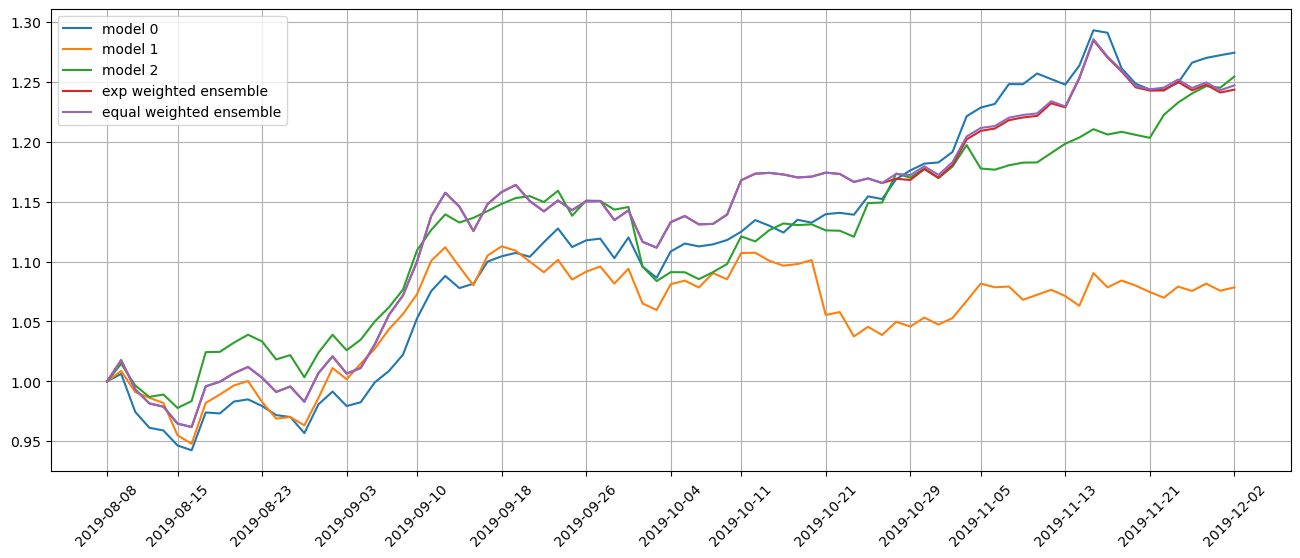

Standardization data are from 2018-04-30 to 2019-02-13
Training data are from 2019-02-14 to 2019-11-27
Testing data are from 2019-11-01 to 2019-12-27
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 5 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0155 - val_loss: 0.0146 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0144 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0144 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0144 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0154 - val_loss: 0.0145 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0154 - val_loss: 0.0143 - lr: 0.0050
Epoch 7/500
305/

305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0147 - lr: 0.0012
Epoch 15/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 0.0012
Epoch 16/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 0.0012
Epoch 17/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 6.2500e-04
Epoch 18/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 6.2500e-04
Epoch 19/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 6.2500e-04
Epoch 20/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 6.2500e-04
Epoch 21/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0149 - val_loss: 0.0146 - lr: 6.2500e-04
Epoch 22/500
305/305 [==============================] - 7s 23ms/s

position on 2019-12-05 market open will be {'FIX': 0.12297258695330764, 'LSCC': 0.12156119385265311, 'EBAY': 0.1251217314590067, 'EGHT': 0.12185859539829594, 'DK': 0.1237642048273366, 'CCEP': 0.123992092641835, 'HPQ': 0.12731115553673664, 'LGIH': 0.12590363584610612, 'FXN': 0.12762421392045403, 'MVIS': 0.1353410235634609}
Total asset on 2019-12-05 will be 1.2554504339991885
It should be the same as 1.2554504339991928
top_stocks by return weighted ensemble to buy on 2019-12-04 are ['LGIH', 'SUN', 'CYH', 'EPR', 'FIX', 'MXL', 'EBAY', 'FXN', 'CCEP', 'HPQ']
position on 2019-12-05 market open will be {'FIX': 0.12222783087854683, 'CCEP': 0.12090481502393076, 'EPR': 0.12379169960654268, 'EBAY': 0.1231412300675763, 'SUN': 0.12120641005898092, 'HPQ': 0.1252959986351737, 'LGIH': 0.1239107580056883, 'FXN': 0.12560410174407738, 'CYH': 0.126210697380559, 'MXL': 0.12357856555035839}
Total asset on 2019-12-05 will be 1.235872106951431
It should be the same as 1.2358721069514342
top_stocks by equal wei

top_stocks by model 2 to buy on 2019-12-09 are ['CHRW', 'FIX', 'XYL', 'NYCB', 'HCC', 'BALL', 'AVNS', 'GDDY', 'SEE', 'RGR']
position on 2019-12-10 market open will be {'GDDY': 0.12500473006905796, 'XYL': 0.1303841731907999, 'FIX': 0.12799055991464975, 'SEE': 0.12814900273954566, 'AVNS': 0.12572019240196444, 'RGR': 0.12871837481421708, 'NYCB': 0.12783024016688024, 'BALL': 0.12992524640777173, 'HCC': 0.12909529623381305, 'CHRW': 0.12729313286523547}
Total asset on 2019-12-10 will be 1.280110948803931
It should be the same as 1.2801109488039355
top_stocks by return weighted ensemble to buy on 2019-12-09 are ['PFF', 'PUK', 'AAP', 'EGHT', 'XYL', 'CHRW', 'RGR', 'NYCB', 'AVNS', 'SEE']
position on 2019-12-10 market open will be {'XYL': 0.1283700710746031, 'PUK': 0.12496220714792003, 'SEE': 0.12587875613437474, 'PFF': 0.12510585817849254, 'AVNS': 0.12349297382124647, 'AAP': 0.12417872590082873, 'EGHT': 0.12566012946918226, 'RGR': 0.12643804139610207, 'NYCB': 0.12556564065714493, 'CHRW': 0.125038

top_stocks by model 2 to buy on 2019-12-12 are ['ALRM', 'WDC', 'AAL', 'FDX', 'SUM', 'HSBC', 'GLW', 'AXL', 'TDW', 'MATX']
position on 2019-12-13 market open will be {'GLW': 0.13346178787931395, 'TDW': 0.1319124538594371, 'SUM': 0.13011125441177634, 'ALRM': 0.1301679207994903, 'HSBC': 0.13193018147952218, 'MATX': 0.1303517943571647, 'AXL': 0.13417576751257906, 'FDX': 0.13343607016302633, 'WDC': 0.13539978379544687, 'AAL': 0.13231618991441982}
Total asset on 2019-12-13 will be 1.3232632041721724
It should be the same as 1.3232632041721766
top_stocks by return weighted ensemble to buy on 2019-12-12 are ['PUK', 'AXL', 'EME', 'FIX', 'WDC', 'AIG', 'MATX', 'GLW', 'SUM', 'HSBC']
position on 2019-12-13 market open will be {'WDC': 0.13570773626771562, 'FIX': 0.12582818248942432, 'GLW': 0.1306628785297098, 'PUK': 0.13058080763484672, 'AIG': 0.1262906941703278, 'MATX': 0.1264679940806943, 'SUM': 0.1262346209649688, 'HSBC': 0.12799935353939423, 'AXL': 0.13017803287815485, 'EME': 0.12478109941789428}

position on 2019-12-18 market open will be {'XRX': 0.1289930568925336, 'FAST': 0.1270092519492269, 'JBLU': 0.13290352897768565, 'LZB': 0.13152630535205295, 'MOS': 0.13512847475881357, 'CMPR': 0.1315712604944725, 'USRT': 0.12906862700183047, 'FL': 0.13359127403525733, 'EME': 0.13151393890522858, 'MVIS': 0.12838463493508687}
Total asset on 2019-12-18 will be 1.309690353302185
It should be the same as 1.3096903533021884
Testing data from 2019-11-19 to 2019-12-17 have shape (2152, 20, 28), (2152,)
top_stocks by model 0 to buy on 2019-12-18 are ['FSS', 'REET', 'GFF', 'ICF', 'ABR', 'SBGI', 'UI', 'SAVE', 'AOS', 'USRT']
position on 2019-12-19 market open will be {'USRT': 0.13151097271751297, 'FSS': 0.13309363957384399, 'AOS': 0.13322829276976864, 'REET': 0.13334283336076577, 'ABR': 0.1325352247735636, 'SBGI': 0.13358592071830416, 'UI': 0.13076505927327703, 'ICF': 0.13364742923609504, 'GFF': 0.1301304281651562, 'SAVE': 0.12968196931578638}
Total asset on 2019-12-19 will be 1.3215217699040738
It

top_stocks by model 0 to buy on 2019-12-23 are ['GFF', 'FL', 'CMPR', 'ROCK', 'OLN', 'HEI', 'XRX', 'RGLD', 'LZB', 'AEM']
position on 2019-12-24 market open will be {'RGLD': 0.13653342339503519, 'HEI': 0.1324367122134548, 'ROCK': 0.13210911314844861, 'AEM': 0.13666085354779156, 'LZB': 0.13407200291878688, 'CMPR': 0.13202017080836972, 'XRX': 0.1329406859297425, 'FL': 0.13347498695961665, 'OLN': 0.1346186057836386, 'GFF': 0.13568755741457605}
Total asset on 2019-12-24 will be 1.3405541121194604
It should be the same as 1.3405541121194604
top_stocks by model 1 to buy on 2019-12-23 are ['SCHW', 'AB', 'ROCK', 'CMPR', 'SPR', 'OLN', 'MCK', 'AEM', 'LZB', 'HPE']
position on 2019-12-24 market open will be {'SPR': 0.11036208234956878, 'ROCK': 0.11135901563312006, 'AEM': 0.11519582384572814, 'LZB': 0.11301359848067556, 'AB': 0.11158229417986966, 'CMPR': 0.11128404327729054, 'OLN': 0.11347434759571755, 'HPE': 0.11323367479967716, 'SCHW': 0.11260725518572075, 'MCK': 0.11113940903401529}
Total asset on

top_stocks by model 0 to buy on 2019-12-27 are ['MSCI', 'AVA', 'TTEK', 'BRC', 'IIPR', 'AMBA', 'RILY', 'MVIS', 'UPBD', 'PI']
position on 2019-12-30 market open will be {'BRC': 0.13529552183141857, 'TTEK': 0.13435360305119892, 'RILY': 0.13415518811934046, 'IIPR': 0.12843249947705607, 'PI': 0.13354723795318466, 'AVA': 0.136161403748217, 'AMBA': 0.13338128557928872, 'MSCI': 0.13522242507784213, 'UPBD': 0.13645932382495626, 'MVIS': 0.13198258906421892}
Total asset on 2019-12-30 will be 1.3389910777267218
It should be the same as 1.3389910777267218
top_stocks by model 1 to buy on 2019-12-27 are ['BECN', 'DELL', 'FNF', 'OLED', 'IRT', 'MVIS', 'PI', 'AVA', 'AMBA', 'MSCI']
position on 2019-12-30 market open will be {'FNF': 0.1124771083465102, 'PI': 0.11110991658765394, 'AVA': 0.1132848754103453, 'BECN': 0.11353694885674004, 'OLED': 0.11042048792689192, 'AMBA': 0.11097184593412561, 'MSCI': 0.11250365489734968, 'IRT': 0.11285836816165373, 'MVIS': 0.10980814494335463, 'DELL': 0.11000447367867683}
T

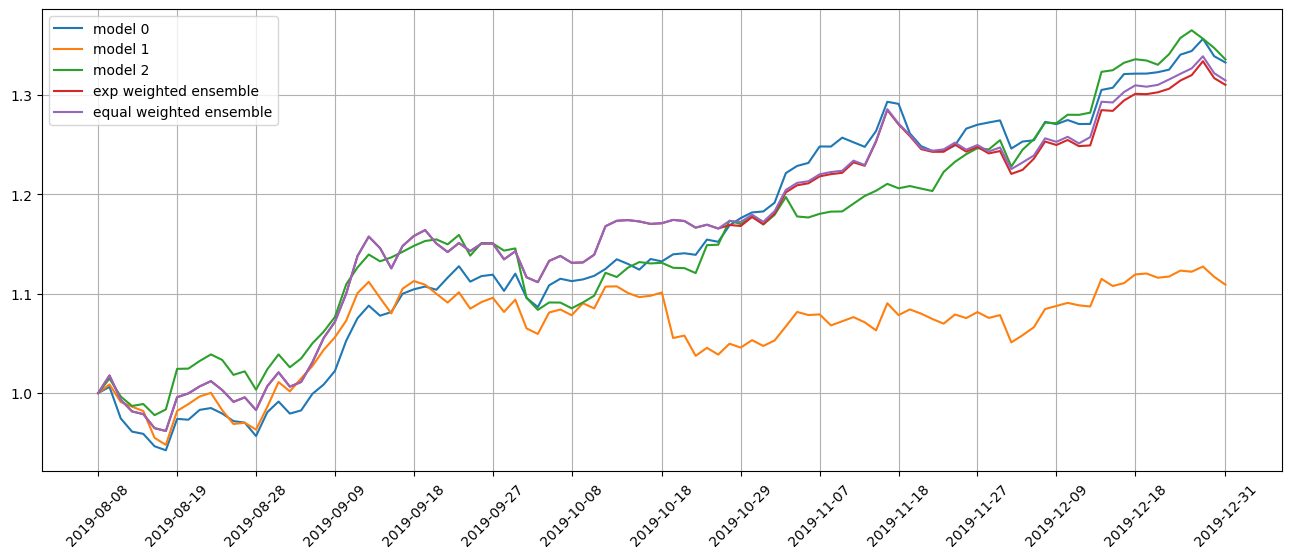

Standardization data are from 2018-05-29 to 2019-03-14
Training data are from 2019-03-15 to 2019-12-27
Testing data are from 2019-12-02 to 2020-01-28
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 6 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0159 - val_loss: 0.0123 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0159 - val_loss: 0.0123 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0158 - val_loss: 0.0121 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0158 - val_loss: 0.0122 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0158 - val_loss: 0.0123 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0158 - val_loss: 0.0123 - lr: 0.0050
Epoch 7/500
305/

305/305 [==============================] - 7s 22ms/step - loss: 0.0153 - val_loss: 0.0123 - lr: 6.2500e-04
Epoch 20/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0154 - val_loss: 0.0122 - lr: 6.2500e-04
Epoch 21/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0153 - val_loss: 0.0122 - lr: 6.2500e-04
Epoch 22/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0153 - val_loss: 0.0122 - lr: 5.0000e-04
Epoch 23/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0153 - val_loss: 0.0122 - lr: 5.0000e-04
Epoch 24/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0153 - val_loss: 0.0122 - lr: 5.0000e-04
Epoch 25/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0153 - val_loss: 0.0123 - lr: 5.0000e-04
Epoch 26/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0153 - val_loss: 0.0123 - lr: 5.0000e-04
Epoch 27/500
305/305 [==============================]

top_stocks by model 1 to buy on 2020-01-03 are ['SLM', 'OKTA', 'TEAM', 'GPI', 'TSEM', 'TER', 'ENTG', 'MDYV', 'AMAT', 'NVMI']
position on 2020-01-06 market open will be {'TEAM': 0.11278260433990794, 'ENTG': 0.11069953219785891, 'AMAT': 0.10982406837353685, 'NVMI': 0.1093223206672683, 'SLM': 0.11048560038406048, 'TSEM': 0.10971219589903139, 'TER': 0.11002508563166569, 'GPI': 0.11119506960510078, 'MDYV': 0.11120084316168308, 'OKTA': 0.11354627996563384}
Total asset on 2020-01-06 will be 1.1087936002257426
It should be the same as 1.1087936002257475
top_stocks by model 2 to buy on 2020-01-03 are ['J', 'FAS', 'BECN', 'NEAR', 'UNG', 'MDYV', 'UUP', 'TEAM', 'TCBI', 'ATSG']
position on 2020-01-06 market open will be {'TEAM': 0.13796691616202855, 'FAS': 0.13522461685506046, 'ATSG': 0.13605654558891364, 'MDYV': 0.1360319483259712, 'J': 0.13860247021944785, 'NEAR': 0.13620622180529585, 'BECN': 0.13791841373111816, 'UNG': 0.13738993803093463, 'TCBI': 0.13559408031839626, 'UUP': 0.1357117539121965}


top_stocks by model 1 to buy on 2020-01-08 are ['AVA', 'MKSI', 'TER', 'AZUL', 'MRVL', 'TRI', 'HEDJ', 'DELL', 'LRCX', 'AMAT']
position on 2020-01-09 market open will be {'AMAT': 0.11314666807189122, 'HEDJ': 0.11353944130201754, 'TER': 0.11309052545749386, 'LRCX': 0.11398777128049402, 'AZUL': 0.11458665202759276, 'AVA': 0.11354956186507993, 'TRI': 0.11340879665693361, 'MRVL': 0.11322091281137374, 'MKSI': 0.11289704346631206, 'DELL': 0.11382432100069043}
Total asset on 2020-01-09 will be 1.1352516939398742
It should be the same as 1.1352516939398791
top_stocks by model 2 to buy on 2020-01-08 are ['CHKP', 'SMH', 'SVXY', 'MRVL', 'SID', 'VEEV', 'XRX', 'HEDJ', 'AOS', 'DELL']
position on 2020-01-09 market open will be {'AOS': 0.1375234824139435, 'DELL': 0.13497541454526563, 'SVXY': 0.14044079236016851, 'CHKP': 0.13653519860509353, 'HEDJ': 0.13977409577594616, 'SMH': 0.14017880287389672, 'MRVL': 0.1393819674437291, 'XRX': 0.1387480291938207, 'VEEV': 0.14117264348055497, 'SID': 0.138571363364625

top_stocks by model 2 to buy on 2020-01-13 are ['UI', 'KRG', 'ULTA', 'RS', 'ALK', 'LYG', 'PDBC', 'IFF', 'NUE', 'ATI']
position on 2020-01-14 market open will be {'PDBC': 0.13783481637449999, 'KRG': 0.1374720834453777, 'ATI': 0.13890189801408276, 'ULTA': 0.1415610401127683, 'ALK': 0.13984610549154522, 'LYG': 0.13746820021304876, 'RS': 0.13907488635177048, 'UI': 0.1398385070444475, 'NUE': 0.13893398013843386, 'IFF': 0.13904634626665735}
Total asset on 2020-01-14 will be 1.3899778634526272
It should be the same as 1.3899778634526319
top_stocks by return weighted ensemble to buy on 2020-01-13 are ['SITC', 'TRN', 'CASY', 'EGHT', 'WOLF', 'ALK', 'NUE', 'IFF', 'LYG', 'ATI']
position on 2020-01-14 market open will be {'ATI': 0.1302186685089099, 'TRN': 0.12850806929679245, 'CASY': 0.13240494514971216, 'WOLF': 0.1337338642597287, 'EGHT': 0.13572567542326436, 'SITC': 0.1338465542686946, 'ALK': 0.13414361937966907, 'LYG': 0.13186267762960496, 'NUE': 0.13326868764121094, 'IFF': 0.1333764718307141}
T

top_stocks by model 2 to buy on 2020-01-16 are ['ENR', 'UNF', 'QTWO', 'VTR', 'EXPRQ', 'CVLT', 'YEXT', 'PBI', 'TGI', 'SPR']
position on 2020-01-17 market open will be {'SPR': 0.13955474895600245, 'TGI': 0.13993107689574524, 'CVLT': 0.1441402593529341, 'ENR': 0.14097655656000557, 'QTWO': 0.14195038729801024, 'UNF': 0.1404856644125617, 'VTR': 0.1439894729925857, 'EXPRQ': 0.14130266969166536, 'PBI': 0.1409073194285974, 'YEXT': 0.1412094433850103}
Total asset on 2020-01-17 will be 1.4144475989731142
It should be the same as 1.4144475989731182
top_stocks by return weighted ensemble to buy on 2020-01-16 are ['DBI', 'VTR', 'EXPRQ', 'YEXT', 'CVLT', 'PBI', 'ENR', 'TGI', 'UNF', 'SPR']
position on 2020-01-17 market open will be {'SPR': 0.1337103791541888, 'TGI': 0.13407094697352678, 'CVLT': 0.13774796589537705, 'ENR': 0.13472456614308184, 'UNF': 0.1342554439485752, 'DBI': 0.13621738909846268, 'VTR': 0.1376038665679858, 'EXPRQ': 0.1350362168972817, 'PBI': 0.13465839952135714, 'YEXT': 0.134947124965

position on 2020-01-23 market open will be {'HEI': 0.13095988382409487, 'HXL': 0.12936594059584078, 'WING': 0.13622467851337142, 'SPR': 0.13604018696948272, 'TGI': 0.1301171910920796, 'SRTY': 0.13577133966763238, 'TREE': 0.13148549743938917, 'KODK': 0.14212628133912417, 'COOP': 0.12795914724091026, 'DRIP': 0.14618064835067834}
Total asset on 2020-01-23 will be 1.3462307950326
It should be the same as 1.3462307950326036
top_stocks by equal weighted ensemble to buy on 2020-01-22 are ['COOP', 'TREE', 'DRIP', 'SRTY', 'WING', 'HXL', 'HEI', 'SPR', 'TGI', 'KODK']
position on 2020-01-23 market open will be {'HEI': 0.13076618862133804, 'HXL': 0.1291746029024812, 'WING': 0.13602319645677022, 'SPR': 0.13583897778367185, 'TGI': 0.12992474226748701, 'SRTY': 0.1355705281183429, 'TREE': 0.13129102483188201, 'KODK': 0.14191607056253222, 'COOP': 0.12776989025437605, 'DRIP': 0.14596444099393205}
Total asset on 2020-01-23 will be 1.3442396627928097
It should be the same as 1.3442396627928135
Testing data

position on 2020-01-28 market open will be {'AIR': 0.13397461833923227, 'IART': 0.13113863602086814, 'GSG': 0.1300738893490324, 'CBT': 0.1294559111296371, 'LYG': 0.13139727013673447, 'HWM': 0.14175012858254388, 'FXN': 0.13008732271563425, 'MAR': 0.1314410957182827, 'H': 0.13543318672822824, 'SBLK': 0.13036138136992895}
Total asset on 2020-01-28 will be 1.3251134400901179
It should be the same as 1.3251134400901223
top_stocks by equal weighted ensemble to buy on 2020-01-27 are ['DBC', 'HWM', 'H', 'MAR', 'IART', 'LYG', 'SBLK', 'GSG', 'AIR', 'FXN']
position on 2020-01-28 market open will be {'AIR': 0.1335822566812935, 'IART': 0.13032350089818184, 'GSG': 0.12926537250784814, 'LYG': 0.13058052738903264, 'DBC': 0.12970119808533, 'HWM': 0.14086903425398503, 'FXN': 0.1292787223749622, 'MAR': 0.1306240805583317, 'H': 0.13459135741972497, 'SBLK': 0.12955107752797332}
Total asset on 2020-01-28 will be 1.3183671276966589
It should be the same as 1.3183671276966633
Testing data from 2019-12-27 to 2

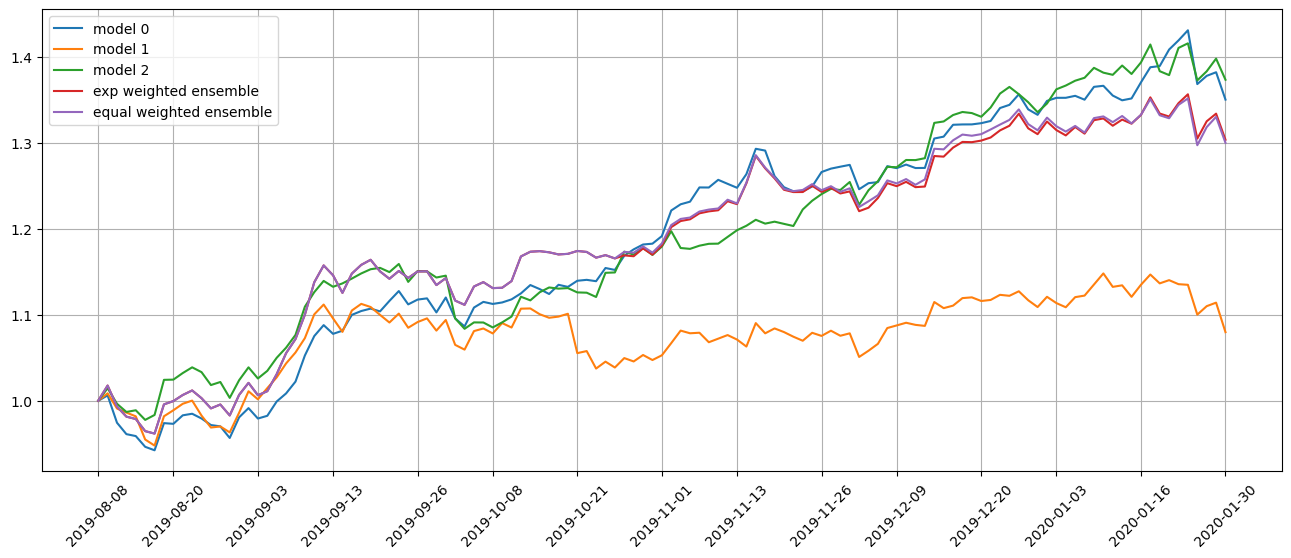

Standardization data are from 2018-06-26 to 2019-04-11
Training data are from 2019-04-12 to 2020-01-28
Testing data are from 2019-12-31 to 2020-02-26
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 7 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0156 - val_loss: 0.0149 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0148 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0148 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0155 - val_loss: 0.0151 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0155 - val_loss: 0.0148 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 22ms/step - loss: 0.0154 - val_loss: 0.0149 - lr: 0.0050
Epoch 7/500
305/

305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0152 - lr: 6.2500e-04
Epoch 21/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0151 - lr: 6.2500e-04
Epoch 22/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0152 - lr: 6.2500e-04
Epoch 23/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0151 - lr: 5.0000e-04
Epoch 24/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0149 - val_loss: 0.0151 - lr: 5.0000e-04
Epoch 25/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 0.0153 - lr: 5.0000e-04
Epoch 25: early stopping
96/96 [==============================] - 2s 23ms/step
Model 0 training loss 0.022364452481269836
11/11 [==============================] - 0s 22ms/step
Model 0 test loss 0.0495309941470623
96/96 [==============================] - 2s 23ms/step
Model 1 training loss 0.02

position on 2020-02-04 market open will be {'TFC': 0.132433481845408, 'NVDA': 0.13456164890481714, 'IYZ': 0.1288244673829858, 'BVN': 0.12901146265440638, 'QLD': 0.1351175389757201, 'OLED': 0.13006048990742516, 'WAFD': 0.13177571586194622, 'EME': 0.13079751464292386, 'GEO': 0.13313845130928795, 'PDCO': 0.1312345711397158}
Total asset on 2020-02-04 will be 1.3169553426246319
It should be the same as 1.3169553426246365
top_stocks by equal weighted ensemble to buy on 2020-02-03 are ['TFC', 'EME', 'GEO', 'QLD', 'OLED', 'NVDA', 'PDCO', 'WAFD', 'IYZ', 'BVN']
position on 2020-02-04 market open will be {'TFC': 0.1319188074381162, 'NVDA': 0.1340387038313414, 'IYZ': 0.1283238186386417, 'BVN': 0.12851008719292742, 'QLD': 0.13459243355435668, 'OLED': 0.1295550376258539, 'WAFD': 0.13126359772149082, 'EME': 0.13028919807232525, 'GEO': 0.13262103718892718, 'PDCO': 0.13072455604250363}
Total asset on 2020-02-04 will be 1.3118372773064797
It should be the same as 1.3118372773064844
Testing data from 202

position on 2020-02-07 market open will be {'XRAY': 0.13678433435185694, 'SLM': 0.13309435750947218, 'BVN': 0.13235030941097295, 'SFM': 0.13181524162865627, 'MKC': 0.13492535559694097, 'SBH': 0.13303423680656085, 'CMPR': 0.13370536036213979, 'LABU': 0.13034210832071988, 'GBTC': 0.1339638975332421, 'GFF': 0.13275668255850942}
Total asset on 2020-02-07 will be 1.3327718840790657
It should be the same as 1.3327718840790712
top_stocks by equal weighted ensemble to buy on 2020-02-06 are ['DDS', 'MKC', 'BVN', 'GBTC', 'SBH', 'SLM', 'LABU', 'CMPR', 'GFF', 'XRAY']
position on 2020-02-07 market open will be {'XRAY': 0.1362507264392451, 'DDS': 0.13493297939086313, 'SLM': 0.13257514452629274, 'BVN': 0.13183399902592072, 'MKC': 0.13439899972658748, 'SBH': 0.1325152583596164, 'CMPR': 0.13318376380222724, 'LABU': 0.12983363210759202, 'GBTC': 0.1334412923967198, 'GFF': 0.1322387868754914}
Total asset on 2020-02-07 will be 1.3312045826505519
It should be the same as 1.3312045826505559
Testing data from

top_stocks by model 0 to buy on 2020-02-12 are ['SBS', 'ALV', 'BANC', 'GPRE', 'AEHR', 'BRZU', 'CLS', 'VIRT', 'BGC', 'FXE']
position on 2020-02-13 market open will be {'BRZU': 0.13998028335805537, 'VIRT': 0.14173798068815538, 'GPRE': 0.1414962554045698, 'AEHR': 0.15062380495393868, 'BGC': 0.14002445460998444, 'FXE': 0.13984627020038498, 'SBS': 0.1416100601107773, 'ALV': 0.1405401979819878, 'CLS': 0.14328580792265527, 'BANC': 0.13816785890403727}
Total asset on 2020-02-13 will be 1.4173129741345452
It should be the same as 1.4173129741345463
top_stocks by model 1 to buy on 2020-02-12 are ['FXE', 'VIRT', 'TMV', 'SSB', 'KAR', 'CRTO', 'TBF', 'LBTYK', 'ENS', 'CLS']
position on 2020-02-13 market open will be {'LBTYK': 0.11411532664140847, 'TMV': 0.1138328536378419, 'VIRT': 0.11491897839029096, 'TBF': 0.11407109085803686, 'FXE': 0.11338520857355375, 'CLS': 0.11617393294551881, 'ENS': 0.1141835930150352, 'SSB': 0.11186306517617436, 'KAR': 0.11645218017034936, 'CRTO': 0.11178689634462353}
Total 

top_stocks by model 0 to buy on 2020-02-18 are ['USO', 'MGY', 'FXN', 'FXE', 'FSLR', 'CIVI', 'PDBC', 'AXSM', 'LYG', 'TDW']
position on 2020-02-19 market open will be {'CIVI': 0.1465779834270884, 'TDW': 0.14172953683336237, 'LYG': 0.13700948185919523, 'PDBC': 0.14156528973426252, 'MGY': 0.13522458770901088, 'FSLR': 0.14147463499236185, 'FXE': 0.13992647355300497, 'USO': 0.14472389922175155, 'FXN': 0.14167772298407721, 'AXSM': 0.1431362876733892}
Total asset on 2020-02-19 will be 1.413045897987503
It should be the same as 1.4130458979875042
top_stocks by model 1 to buy on 2020-02-18 are ['WW', 'TROX', 'VRN', 'TDW', 'FXE', 'TBT', 'SGH', 'CIVI', 'SEE', 'TMV']
position on 2020-02-19 market open will be {'CIVI': 0.11795763363272097, 'TDW': 0.11435722358902556, 'SGH': 0.11070294373288164, 'SEE': 0.11383102379441261, 'TMV': 0.11384785300504757, 'TBT': 0.1136183951473788, 'VRN': 0.11445466646235432, 'TROX': 0.11671324241569951, 'WW': 0.11724959276403764, 'FXE': 0.1133826012332566}
Total asset on

top_stocks by model 0 to buy on 2020-02-21 are ['ECH', 'VRN', 'FENY', 'IYE', 'SLB', 'NBR', 'LYG', 'PBF', 'DK', 'ERX']
position on 2020-02-24 market open will be {'ECH': 0.1363010177921286, 'IYE': 0.1372168345059079, 'ERX': 0.1267782979736556, 'NBR': 0.1366111656947783, 'SLB': 0.13621628701032445, 'VRN': 0.13452933772279513, 'DK': 0.1401761082398725, 'PBF': 0.13369701843023732, 'LYG': 0.13396737353627425, 'FENY': 0.13748567022736513}
Total asset on 2020-02-24 will be 1.3529791111333382
It should be the same as 1.3529791111333394
top_stocks by model 1 to buy on 2020-02-21 are ['EZA', 'EWD', 'SAN', 'BAP', 'YINN', 'LYG', 'ENS', 'MSM', 'DK', 'ECH']
position on 2020-02-24 market open will be {'ECH': 0.11081683946015088, 'MSM': 0.10933636567994835, 'DK': 0.11074790842443531, 'EZA': 0.10839453663527548, 'LYG': 0.1058426189923085, 'YINN': 0.0986493449980527, 'ENS': 0.109765870328245, 'EWD': 0.10711085938351536, 'SAN': 0.10791895263229877, 'BAP': 0.11098746281603507}
Total asset on 2020-02-24 wi

top_stocks by model 0 to buy on 2020-02-26 are ['BNO', 'DBA', 'META', 'JBHT', 'WMB', 'NGVT', 'USO', 'DBO', 'DBC', 'GSG']
position on 2020-02-27 market open will be {'GSG': 0.12938724452946068, 'DBO': 0.12941582267228566, 'WMB': 0.13101597908241758, 'BNO': 0.12667189322479758, 'JBHT': 0.13082808344493105, 'DBC': 0.1310465953506283, 'USO': 0.1259995546199465, 'DBA': 0.13386327026668202, 'META': 0.13089079402770604, 'NGVT': 0.1256462371092051}
Total asset on 2020-02-27 will be 1.2947654743280594
It should be the same as 1.2947654743280606
top_stocks by model 1 to buy on 2020-02-26 are ['SPSC', 'UDOW', 'BK', 'EWI', 'XBI', 'BOTZ', 'IWM', 'TNA', 'TEL', 'META']
position on 2020-02-27 market open will be {'BK': 0.10258413561512279, 'EWI': 0.10410081266923968, 'META': 0.10301750190751773, 'TEL': 0.10255170319086168, 'UDOW': 0.09736262789954526, 'TNA': 0.09444455212803532, 'BOTZ': 0.10281499670462053, 'IWM': 0.10205786929638198, 'SPSC': 0.10357780482612698, 'XBI': 0.10392794032302372}
Total asse

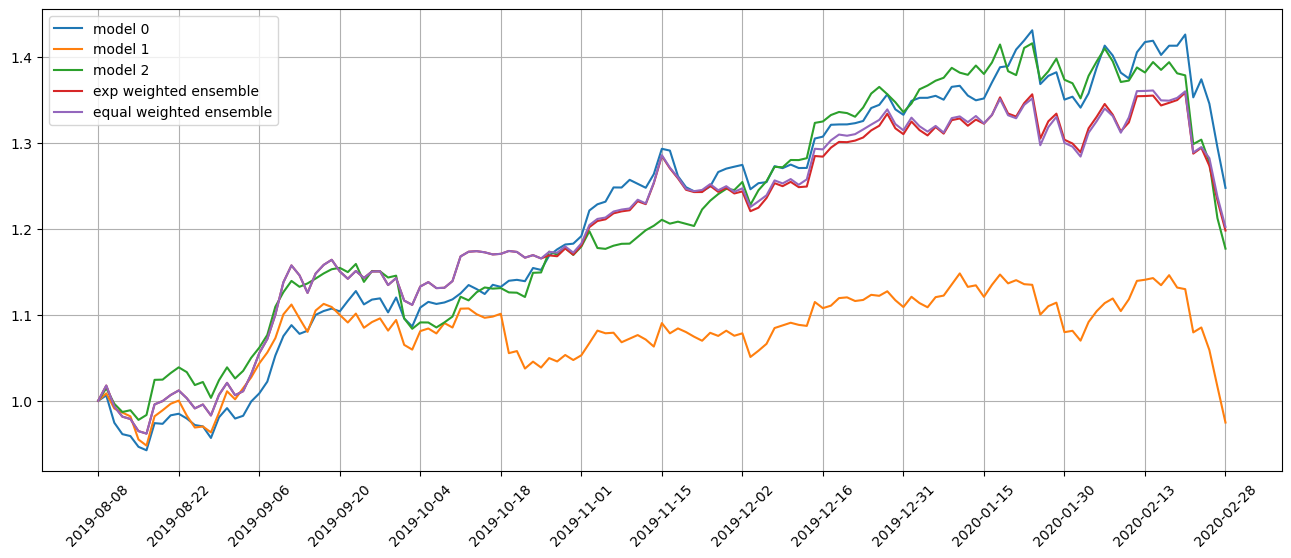

Standardization data are from 2018-07-25 to 2019-05-10
Training data are from 2019-05-13 to 2020-02-26
Testing data are from 2020-01-30 to 2020-03-25
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 8 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0148 - val_loss: 0.0334 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0148 - val_loss: 0.0298 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0147 - val_loss: 0.0316 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0147 - val_loss: 0.0299 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0147 - val_loss: 0.0306 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0147 - val_loss: 0.0302 - lr: 0.0050
Epoch 7/500
305/

305/305 [==============================] - 7s 23ms/step - loss: 0.0143 - val_loss: 0.0326 - lr: 6.2500e-04
Epoch 20/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0143 - val_loss: 0.0319 - lr: 6.2500e-04
Epoch 21/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0143 - val_loss: 0.0324 - lr: 6.2500e-04
Epoch 22/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0143 - val_loss: 0.0316 - lr: 6.2500e-04
Epoch 22: early stopping
96/96 [==============================] - 2s 23ms/step
Model 0 training loss 0.02416219748556614
11/11 [==============================] - 0s 22ms/step
Model 0 test loss 0.1502414494752884
96/96 [==============================] - 2s 23ms/step
Model 1 training loss 0.02418028935790062
11/11 [==============================] - 0s 22ms/step
Model 1 test loss 0.15831899642944336
96/96 [==============================] - 2s 23ms/step
Model 2 training loss 0.0231251809746027
11/11 [==============================]

position on 2020-03-04 market open will be {'TFIN': 0.12821674197606228, 'FIX': 0.13335058411187686, 'CDP': 0.13373541497683086, 'CVBF': 0.1290281287339969, 'CATY': 0.12555723179516326, 'GD': 0.1286862123054394, 'ITB': 0.13313760929710888, 'BDN': 0.13248303647222512, 'NEOG': 0.12899963151359925, 'TCBI': 0.12675645170953578}
Total asset on 2020-03-04 will be 1.299951042891831
It should be the same as 1.2999510428918388
top_stocks by equal weighted ensemble to buy on 2020-03-03 are ['BDN', 'GD', 'CADE', 'FIX', 'TFIN', 'ITB', 'NEOG', 'CDP', 'CVBF', 'TCBI']
position on 2020-03-04 market open will be {'TFIN': 0.1291114443077873, 'FIX': 0.13428111063051248, 'CDP': 0.1346686268629691, 'CVBF': 0.12992849295989475, 'GD': 0.12958419062274862, 'ITB': 0.1340666496676765, 'BDN': 0.13340750920346828, 'NEOG': 0.12989979688458045, 'CADE': 0.1293177518049825, 'TCBI': 0.1276409640685137}
Total asset on 2020-03-04 will be 1.3119065370131289
It should be the same as 1.3119065370131338
Testing data from 20

top_stocks by model 0 to buy on 2020-03-09 are ['SNN', 'TPIC', 'SGH', 'IJK', 'EXTR', 'IJT', 'NSC', 'KEX', 'IJH', 'FL']
position on 2020-03-10 market open will be {'NSC': 0.12024028366201854, 'KEX': 0.1152450807701307, 'IJK': 0.12180116261066509, 'EXTR': 0.12319765586726421, 'TPIC': 0.10925052127920987, 'IJT': 0.12544830168444168, 'SNN': 0.118881200507612, 'IJH': 0.12051949530131063, 'FL': 0.12562117071899864, 'SGH': 0.12193930760925192}
Total asset on 2020-03-10 will be 1.202144180010903
It should be the same as 1.2021441800109032
top_stocks by model 1 to buy on 2020-03-09 are ['BRO', 'MCO', 'MODG', 'FMC', 'CDNS', 'HLT', 'NSC', 'SKX', 'CACI', 'FL']
position on 2020-03-10 market open will be {'MODG': 0.09473958908257003, 'NSC': 0.09968753207250353, 'MCO': 0.10000171368102831, 'CDNS': 0.0981607692755836, 'FL': 0.10414866052907805, 'BRO': 0.09698265880123359, 'CACI': 0.10171203169292267, 'HLT': 0.10660848099984176, 'SKX': 0.097193346451225, 'FMC': 0.09688394081226785}
Total asset on 2020-

top_stocks by model 0 to buy on 2020-03-12 are ['TCBI', 'CDP', 'XBI', 'WPC', 'TAP', 'JHG', 'BDN', 'NNN', 'TX', 'CMP']
position on 2020-03-13 market open will be {'CMP': 0.11281468925688287, 'NNN': 0.11033972434906276, 'CDP': 0.1077850359866769, 'JHG': 0.10808394631689183, 'BDN': 0.10380129397305914, 'TX': 0.10510037721030943, 'TCBI': 0.11574064596125187, 'XBI': 0.10797069338120233, 'TAP': 0.11055589505287014, 'WPC': 0.10560202647827217}
Total asset on 2020-03-13 will be 1.087794327966479
It should be the same as 1.0877943279664795
top_stocks by model 1 to buy on 2020-03-12 are ['LTC', 'CPB', 'SLG', 'APPF', 'CDP', 'SBRA', 'VOD', 'CDNA', 'VRNT', 'CMP']
position on 2020-03-13 market open will be {'APPF': 0.08345901234079826, 'CMP': 0.09053888135585449, 'CDP': 0.08650235753354132, 'VOD': 0.08757394558463052, 'CPB': 0.08579575991370297, 'CDNA': 0.08796027180154464, 'VRNT': 0.08292805413996777, 'SLG': 0.08539170966108056, 'SBRA': 0.07367472732061331, 'LTC': 0.0769181072229917}
Total asset on

top_stocks by model 0 to buy on 2020-03-17 are ['TTMI', 'SJM', 'BRC', 'CPB', 'GDOT', 'MGY', 'TFI', 'ARR', 'TAK', 'AVAV']
position on 2020-03-18 market open will be {'BRC': 0.1135426107751353, 'TFI': 0.09912734566055402, 'GDOT': 0.08622860860948288, 'MGY': 0.083109510870937, 'ARR': 0.08662804998807104, 'SJM': 0.10538705046469629, 'CPB': 0.10704173349156092, 'TTMI': 0.10628792567331022, 'AVAV': 0.10048328622024948, 'TAK': 0.09790573981627186}
Total asset on 2020-03-18 will be 0.9857418615702688
It should be the same as 0.985741861570269
top_stocks by model 1 to buy on 2020-03-17 are ['TRV', 'MAT', 'TEAM', 'SJM', 'AVAV', 'CALM', 'ARR', 'TTMI', 'CPB', 'MTG']
position on 2020-03-18 market open will be {'TEAM': 0.0709486567688539, 'TRV': 0.07772247484642864, 'ARR': 0.06458697888256798, 'SJM': 0.07857306269501345, 'TTMI': 0.07924472514248386, 'CPB': 0.07980673905882593, 'MAT': 0.07566905880386893, 'MTG': 0.06971400988048566, 'AVAV': 0.074916979962633, 'CALM': 0.07791181784720268}
Total asset 

top_stocks by model 0 to buy on 2020-03-20 are ['GKOS', 'KAR', 'WDC', 'JAZZ', 'GPK', 'SIMO', 'KKR', 'SYF', 'PNFP', 'PYPL']
position on 2020-03-23 market open will be {'KKR': 0.08894448315522237, 'GPK': 0.09598477725276877, 'PYPL': 0.09221410330348183, 'GKOS': 0.08989330947477632, 'JAZZ': 0.09579119997064947, 'SYF': 0.09066772042188397, 'SIMO': 0.09576230991404955, 'WDC': 0.10138457692799162, 'PNFP': 0.09574785497980265, 'KAR': 0.09401693155737}
Total asset on 2020-03-23 will be 0.9404072669579963
It should be the same as 0.9404072669579966
top_stocks by model 1 to buy on 2020-03-20 are ['INVH', 'SYF', 'SAIC', 'PNFP', 'IIPR', 'GNTX', 'NOVT', 'DHR', 'WDC', 'GLOB']
position on 2020-03-23 market open will be {'DHR': 0.07901303589405533, 'INVH': 0.06616486030230348, 'GNTX': 0.06720360152110734, 'IIPR': 0.08228508721636894, 'SYF': 0.06490116918596554, 'NOVT': 0.0686571987624414, 'SAIC': 0.06775653680621721, 'GLOB': 0.06608993036366971, 'WDC': 0.07257243867424895, 'PNFP': 0.06853759757411515}

top_stocks by model 0 to buy on 2020-03-25 are ['ONB', 'MWA', 'CCI', 'NGG', 'FLO', 'AVA', 'PGR', 'KMB', 'ABM', 'CMP']
position on 2020-03-26 market open will be {'PGR': 0.09561980752892293, 'KMB': 0.09547892676653333, 'ONB': 0.09313657177682767, 'CMP': 0.09869122403893234, 'ABM': 0.09947809129177623, 'NGG': 0.10566550922820996, 'CCI': 0.10364578913086055, 'FLO': 0.09321824355015293, 'AVA': 0.09810737995710626, 'MWA': 0.10198964863317635}
Total asset on 2020-03-26 will be 0.9850311919024983
It should be the same as 0.9850311919024985
top_stocks by model 1 to buy on 2020-03-25 are ['WM', 'KMB', 'XYL', 'XLP', 'PRGO', 'PGR', 'KFY', 'CCI', 'NGG', 'AMN']
position on 2020-03-26 market open will be {'PRGO': 0.07374914553176919, 'KMB': 0.0739701937260301, 'XYL': 0.07841682731425138, 'PGR': 0.07656633031846595, 'XLP': 0.0754081290223254, 'KFY': 0.07488111256927754, 'CCI': 0.07759497628423244, 'NGG': 0.07910705057464806, 'WM': 0.07376668361225384, 'AMN': 0.0654123640995894}
Total asset on 2020-03

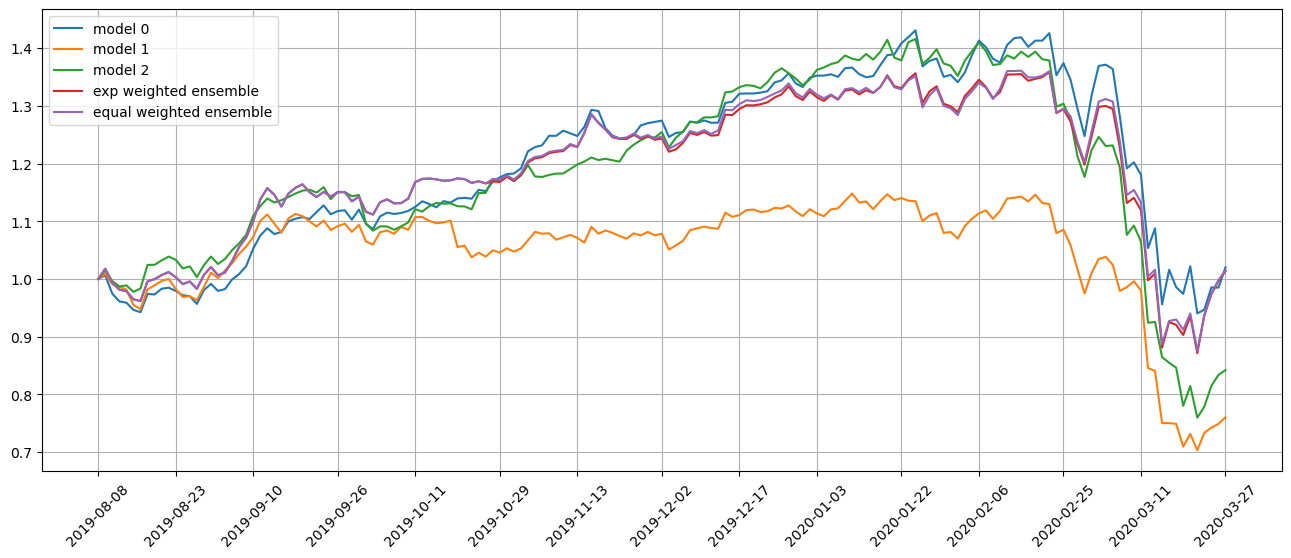

Standardization data are from 2018-08-22 to 2019-06-10
Training data are from 2019-06-11 to 2020-03-25
Testing data are from 2020-02-28 to 2020-04-23
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 9 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0152 - val_loss: 0.0964 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0152 - val_loss: 0.1063 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0152 - val_loss: 0.0958 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0151 - val_loss: 0.1162 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0151 - val_loss: 0.1058 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0151 - val_loss: 0.1051 - lr: 0.0050
Epoch 7/500
305/

305/305 [==============================] - 7s 23ms/step - loss: 0.0147 - val_loss: 0.1246 - lr: 0.0012
Epoch 21/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0147 - val_loss: 0.1280 - lr: 6.2500e-04
Epoch 22/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0146 - val_loss: 0.1217 - lr: 6.2500e-04
Epoch 23/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0146 - val_loss: 0.1281 - lr: 6.2500e-04
Epoch 24/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0146 - val_loss: 0.1344 - lr: 6.2500e-04
Epoch 25/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0146 - val_loss: 0.1261 - lr: 6.2500e-04
Epoch 25: early stopping
96/96 [==============================] - 2s 23ms/step
Model 0 training loss 0.03922146186232567
11/11 [==============================] - 0s 22ms/step
Model 0 test loss 0.09402354061603546
96/96 [==============================] - 2s 23ms/step
Model 1 training loss 0.036479

position on 2020-04-01 market open will be {'CHKP': 0.10179168472416407, 'WTFC': 0.09683937480596304, 'ADBE': 0.09822476709860369, 'TEVA': 0.09695160297229975, 'CAT': 0.10247888225991736, 'AMG': 0.0939217238501126, 'LVS': 0.09396444551018858, 'URI': 0.10317251330507883, 'FL': 0.09429597646619944, 'PDCO': 0.0917155024514222}
Total asset on 2020-04-01 will be 0.9733564734439422
It should be the same as 0.9733564734439496
top_stocks by equal weighted ensemble to buy on 2020-03-31 are ['CHKP', 'ADBE', 'WTFC', 'LVS', 'URI', 'AMG', 'CAT', 'TEVA', 'FL', 'PDCO']
position on 2020-04-01 market open will be {'CHKP': 0.10256619216332044, 'WTFC': 0.0975762013590721, 'ADBE': 0.09897213475474792, 'TEVA': 0.09768928344142315, 'CAT': 0.10325861841304043, 'AMG': 0.09463635072771487, 'LVS': 0.09467939744620432, 'URI': 0.10395752712313065, 'FL': 0.09501345093823997, 'PDCO': 0.09241334274286722}
Total asset on 2020-04-01 will be 0.9807624991097552
It should be the same as 0.9807624991097612
Testing data fr

top_stocks by model 0 to buy on 2020-04-06 are ['TROX', 'WTFC', 'ALSN', 'ROG', 'LABU', 'SID', 'RAMP', 'KURA', 'YEXT', 'KFY']
position on 2020-04-07 market open will be {'WTFC': 0.1027346486239909, 'KURA': 0.10056015026233552, 'KFY': 0.10111583916090917, 'ROG': 0.10270605076778905, 'TROX': 0.10531359108279466, 'ALSN': 0.10789699960767106, 'LABU': 0.11165305873907494, 'SID': 0.10177342224283284, 'RAMP': 0.10074987322530052, 'YEXT': 0.10775856154400294}
Total asset on 2020-04-07 will be 1.0422621952567013
It should be the same as 1.0422621952567015
top_stocks by model 1 to buy on 2020-04-06 are ['BCO', 'SFM', 'TAP', 'SBLK', 'TREE', 'YEXT', 'ROG', 'LSTR', 'IP', 'KFY']
position on 2020-04-07 market open will be {'IP': 0.07929701420000886, 'BCO': 0.08013285663539163, 'TREE': 0.0930175697748095, 'SFM': 0.07602171026474558, 'KFY': 0.0796612673777312, 'ROG': 0.08091407082627147, 'LSTR': 0.08115965004541459, 'TAP': 0.07933371713078674, 'YEXT': 0.08489454920842036, 'SBLK': 0.08109161704596685}
To

top_stocks by model 0 to buy on 2020-04-09 are ['CUBI', 'BGC', 'BKR', 'ASGN', 'YEXT', 'THO', 'WTFC', 'LABU', 'AEHR', 'KODK']
position on 2020-04-13 market open will be {'CUBI': 0.1181353722029483, 'ASGN': 0.11078663585542567, 'WTFC': 0.1087671562567433, 'THO': 0.111625013384547, 'BGC': 0.11481138213697285, 'AEHR': 0.1135286970453518, 'KODK': 0.11725581025114479, 'LABU': 0.10924478684617182, 'BKR': 0.10597085643401451, 'YEXT': 0.11272290796606513}
Total asset on 2020-04-13 will be 1.1228486183793853
It should be the same as 1.1228486183793853
top_stocks by model 1 to buy on 2020-04-09 are ['BECN', 'LUMN', 'KFY', 'KALU', 'THO', 'DXD', 'PII', 'GPRE', 'YEXT', 'HGV']
position on 2020-04-13 market open will be {'THO': 0.08371166374177991, 'DXD': 0.08223456023088135, 'KFY': 0.08082397303203455, 'GPRE': 0.08166864351506671, 'BECN': 0.08617505451276734, 'YEXT': 0.08453501488186309, 'PII': 0.08289225830622303, 'LUMN': 0.0857644166278207, 'HGV': 0.07549271339329643, 'KALU': 0.08080976478889738}
T

top_stocks by model 0 to buy on 2020-04-15 are ['KT', 'LIVN', 'YINN', 'CUBI', 'SBLK', 'NSP', 'CRS', 'HCC', 'TCBI', 'CBT']
position on 2020-04-16 market open will be {'CRS': 0.09754897349592817, 'CBT': 0.1055092394873956, 'CUBI': 0.10512943234714789, 'KT': 0.10537737022815974, 'NSP': 0.10578994913001992, 'HCC': 0.09944291113361146, 'YINN': 0.10688157367799371, 'SBLK': 0.10657441086215472, 'TCBI': 0.10521519429513539, 'LIVN': 0.11186116257990221}
Total asset on 2020-04-16 will be 1.0493302172374495
It should be the same as 1.0493302172374488
top_stocks by model 1 to buy on 2020-04-15 are ['TXT', 'CBT', 'CF', 'EXTR', 'DDS', 'NLY', 'BECN', 'FTI', 'SBLK', 'CUBI']
position on 2020-04-16 market open will be {'CBT': 0.07706779579374043, 'TXT': 0.07556178849953694, 'SBLK': 0.08190556814041476, 'CF': 0.07727828252793309, 'CUBI': 0.07848999942271474, 'EXTR': 0.07797460678972853, 'DDS': 0.07534452126811338, 'BECN': 0.07803641417672198, 'FTI': 0.07955204024520474, 'NLY': 0.07849288895009465}
Total 

top_stocks by model 0 to buy on 2020-04-20 are ['FXE', 'IAT', 'SBLK', 'BANC', 'ROG', 'KAR', 'HBAN', 'CNH', 'CUBI', 'FULT']
position on 2020-04-21 market open will be {'FULT': 0.10416759601571393, 'KAR': 0.10048275158825609, 'SBLK': 0.09438964933442245, 'HBAN': 0.10428514300738062, 'CUBI': 0.10028628579532937, 'CNH': 0.10314336115393705, 'IAT': 0.10334877176075505, 'ROG': 0.1009033135076411, 'FXE': 0.10385706223411709, 'BANC': 0.10403143260604497}
Total asset on 2020-04-21 will be 1.0188953670035983
It should be the same as 1.0188953670035978
top_stocks by model 1 to buy on 2020-04-20 are ['AFG', 'IVZ', 'WWW', 'EWW', 'TXT', 'OXM', 'SBLK', 'ACHC', 'KAR', 'ROG']
position on 2020-04-21 market open will be {'SBLK': 0.07364731922701143, 'ROG': 0.07633063053624874, 'EWW': 0.07614326693193721, 'IVZ': 0.07769514400570805, 'OXM': 0.07574567323426593, 'ACHC': 0.07517083456753303, 'AFG': 0.07385700304825818, 'WWW': 0.07341599756439872, 'KAR': 0.07552515334262284, 'TXT': 0.07535817782631571}
Total 

top_stocks by model 0 to buy on 2020-04-23 are ['PDCO', 'HOG', 'SYF', 'DORM', 'JCI', 'BBD', 'FCFS', 'FULT', 'EWW', 'SBLK']
position on 2020-04-24 market open will be {'DORM': 0.10421365122735253, 'SBLK': 0.11159757797189218, 'FULT': 0.10876395358256444, 'FCFS': 0.10525580493799816, 'SYF': 0.10845268223328854, 'JCI': 0.10668874057931009, 'HOG': 0.10800060271723896, 'EWW': 0.10580540125796695, 'PDCO': 0.1063367495867977, 'BBD': 0.09778760426550602}
Total asset on 2020-04-24 will be 1.0629027683599164
It should be the same as 1.0629027683599155
top_stocks by model 1 to buy on 2020-04-23 are ['VMI', 'COTY', 'SNBR', 'FCFS', 'FLEX', 'BECN', 'GNW', 'GOGO', 'DBC', 'COMT']
position on 2020-04-24 market open will be {'SNBR': 0.1124983948731634, 'COTY': 0.08248315240670893, 'GOGO': 0.07415983573356646, 'VMI': 0.07680282608893428, 'FCFS': 0.07517451965446612, 'FLEX': 0.07811239365611583, 'BECN': 0.08014254665553418, 'GNW': 0.0760881403579639, 'DBC': 0.07536901367857823, 'COMT': 0.07700403148207054

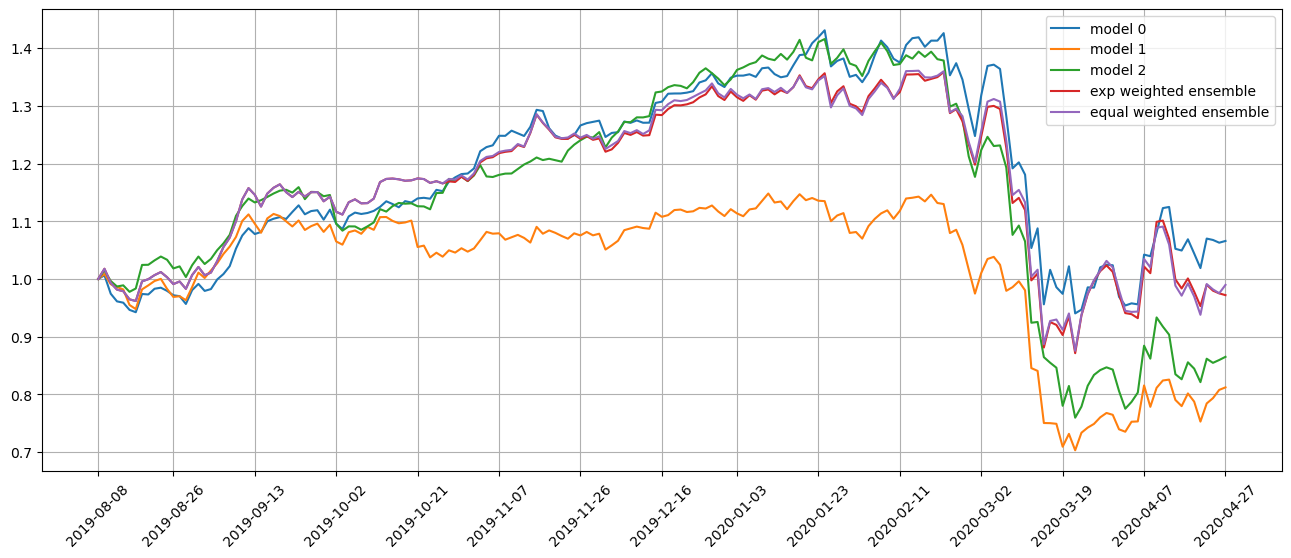

Standardization data are from 2018-09-20 to 2019-07-09
Training data are from 2019-07-10 to 2020-04-23
Testing data are from 2020-03-27 to 2020-05-21
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 10 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0169 - val_loss: 0.0954 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0168 - val_loss: 0.0984 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0167 - val_loss: 0.1039 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0167 - val_loss: 0.1006 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0166 - val_loss: 0.0982 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0166 - val_loss: 0.1104 - lr: 0.0050
Epoch 7/500
305

305/305 [==============================] - 7s 23ms/step - loss: 0.0160 - val_loss: 0.1418 - lr: 6.2500e-04
Epoch 25/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0160 - val_loss: 0.1329 - lr: 6.2500e-04
Epoch 25: early stopping
96/96 [==============================] - 2s 23ms/step
Model 0 training loss 0.0397828035056591
11/11 [==============================] - 0s 22ms/step
Model 0 test loss 0.0660700723528862
96/96 [==============================] - 2s 23ms/step
Model 1 training loss 0.04092886671423912
11/11 [==============================] - 0s 22ms/step
Model 1 test loss 0.07199329137802124
96/96 [==============================] - 2s 23ms/step
Model 2 training loss 0.042651060968637466
11/11 [==============================] - 0s 22ms/step
Model 2 test loss 0.06917630136013031
Correlations between old and new weights
0.9967956855649202
0.9954956083123373
0.993567029098219
0.9938959291661462
0.983789104013488
0.9901884663262711
Weight of model 0 is 0.365580446

position on 2020-04-30 market open will be {'TBT': 0.09849327785572146, 'GOGO': 0.11449403333618711, 'BDC': 0.09763979357774004, 'FOXF': 0.11271970726297939, 'ARCB': 0.1079795133272856, 'VICR': 0.10885380698996891, 'HCSG': 0.10534282175205886, 'HCC': 0.11248689133739416, 'ABCB': 0.10643417494945585, 'SBLK': 0.10211730607455685}
Total asset on 2020-04-30 will be 1.0665613264633422
It should be the same as 1.0665613264633484
Testing data from 2020-04-01 to 2020-04-29 have shape (2152, 20, 28), (2152,)
top_stocks by model 0 to buy on 2020-04-30 are ['HPQ', 'FLO', 'DK', 'AVAV', 'FULT', 'MATX', 'PRTA', 'WBA', 'DINO', 'TBT']
position on 2020-05-01 market open will be {'TBT': 0.11402496527005224, 'FULT': 0.11365005383988565, 'WBA': 0.11289994702790504, 'DINO': 0.11410333867593142, 'PRTA': 0.11891544789487242, 'DK': 0.11357178311943789, 'MATX': 0.11261594182230648, 'FLO': 0.11764313507899536, 'HPQ': 0.11122160361849451, 'AVAV': 0.11609933471420106}
Total asset on 2020-05-01 will be 1.144745551

top_stocks by model 0 to buy on 2020-05-05 are ['ADM', 'TTEK', 'SVXY', 'PPG', 'VMI', 'RYAAY', 'ARCB', 'CAT', 'YY', 'MC']
position on 2020-05-06 market open will be {'MC': 0.11939964624888724, 'CAT': 0.11460846720353987, 'SVXY': 0.11938200666850318, 'PPG': 0.12004646055012651, 'VMI': 0.11480672938360854, 'TTEK': 0.11976463605239786, 'ADM': 0.11794773722641289, 'ARCB': 0.12578257750708377, 'RYAAY': 0.11812121747982572, 'YY': 0.11526875135521396}
Total asset on 2020-05-06 will be 1.1851282296755998
It should be the same as 1.1851282296755994
top_stocks by model 1 to buy on 2020-05-05 are ['CAH', 'CNH', 'BHP', 'NTR', 'BWXT', 'YINN', 'SSYS', 'EWH', 'TTEK', 'CAT']
position on 2020-05-06 market open will be {'TTEK': 0.09049840530865895, 'CNH': 0.08736520532744525, 'EWH': 0.09041005119529257, 'CAT': 0.08994915896228525, 'NTR': 0.08868591785765251, 'BHP': 0.09061263605795883, 'YINN': 0.09207005324022562, 'BWXT': 0.09217699461057235, 'SSYS': 0.08797197763260431, 'CAH': 0.08982931026766389}
Total

top_stocks by model 0 to buy on 2020-05-08 are ['SWK', 'GSG', 'EVR', 'BEN', 'CAT', 'IVR', 'GBX', 'MS', 'TXT', 'WLY']
position on 2020-05-11 market open will be {'CAT': 0.1185049483971577, 'GBX': 0.12186651903640563, 'GSG': 0.1199164477261316, 'IVR': 0.12032108077483715, 'SWK': 0.12288256298879795, 'MS': 0.11860248654264531, 'EVR': 0.11839361218017426, 'WLY': 0.12135728378734226, 'BEN': 0.12262147240973026, 'TXT': 0.12139746936979204}
Total asset on 2020-05-11 will be 1.2058638832130144
It should be the same as 1.2058638832130142
top_stocks by model 1 to buy on 2020-05-08 are ['WLY', 'VMC', 'FCN', 'MCO', 'AX', 'GBX', 'HRI', 'MCY', 'WERN', 'CAT']
position on 2020-05-11 market open will be {'CAT': 0.09016154014806235, 'VMC': 0.08822135725925576, 'GBX': 0.09103398946398447, 'HRI': 0.09590775934965073, 'WERN': 0.0890169928294159, 'MCO': 0.08790308948122331, 'FCN': 0.08722483018484588, 'WLY': 0.09065359198759414, 'MCY': 0.0888631301958075, 'AX': 0.09019046407944434}
Total asset on 2020-05-11

top_stocks by model 0 to buy on 2020-05-13 are ['RBC', 'VZ', 'CVCO', 'JCI', 'TRV', 'VIRT', 'GATX', 'QCOM', 'INFN', 'BDC']
position on 2020-05-14 market open will be {'VIRT': 0.11104332029884813, 'GATX': 0.1076006593674913, 'QCOM': 0.11488607619119168, 'TRV': 0.11102367073219373, 'BDC': 0.10246151152771352, 'VZ': 0.11550338615343476, 'JCI': 0.11500370028039197, 'CVCO': 0.1088901387209443, 'RBC': 0.11158277319564319, 'INFN': 0.10101484195978627}
Total asset on 2020-05-14 will be 1.0990100784276389
It should be the same as 1.0990100784276389
top_stocks by model 1 to buy on 2020-05-13 are ['VIRT', 'PWR', 'DG', 'SKYY', 'RWM', 'BCC', 'TTMI', 'OEF', 'XLG', 'DXD']
position on 2020-05-14 market open will be {'VIRT': 0.08348177129556895, 'RWM': 0.09114133194962465, 'XLG': 0.08513464111343888, 'BCC': 0.08257677355732097, 'TTMI': 0.08257420138702244, 'DG': 0.08638148116062352, 'OEF': 0.08519432211489089, 'DXD': 0.09228374447205437, 'SKYY': 0.08430244540047487, 'PWR': 0.08201636277544494}
Total ass

top_stocks by model 0 to buy on 2020-05-18 are ['RYAAY', 'LSTR', 'UPS', 'UHAL', 'SNDR', 'IONS', 'KALU', 'HII', 'TDC', 'MC']
position on 2020-05-19 market open will be {'HII': 0.12014920516176103, 'KALU': 0.12594854344357423, 'UPS': 0.12093729678235594, 'UHAL': 0.1189846870054507, 'SNDR': 0.12122496143916424, 'MC': 0.12016981276922686, 'RYAAY': 0.12120000820180532, 'LSTR': 0.12269243019492972, 'IONS': 0.11888918785945789, 'TDC': 0.12167601509778903}
Total asset on 2020-05-19 will be 1.211872147955515
It should be the same as 1.211872147955515
top_stocks by model 1 to buy on 2020-05-18 are ['ATSG', 'FDX', 'AEO', 'IONS', 'NOK', 'LMT', 'FOLD', 'GPRO', 'OSIS', 'RYAAY']
position on 2020-05-19 market open will be {'LMT': 0.09246621539594609, 'OSIS': 0.09147411870705441, 'ATSG': 0.09294443230907748, 'GPRO': 0.0923881747985751, 'NOK': 0.09227303746684055, 'RYAAY': 0.09297202764221077, 'IONS': 0.09119940686493175, 'FDX': 0.0946381217525088, 'FOLD': 0.09098636687989398, 'AEO': 0.09152734834154314

top_stocks by model 0 to buy on 2020-05-21 are ['ZWS', 'IWY', 'CNC', 'IWN', 'RITM', 'VSH', 'TQQQ', 'JCI', 'FIX', 'OC']
position on 2020-05-22 market open will be {'JCI': 0.12165141133488613, 'CNC': 0.12380558635699107, 'FIX': 0.12098598248755221, 'IWN': 0.1214832334509713, 'RITM': 0.12666678517800964, 'OC': 0.12690621247004402, 'VSH': 0.11876740308407827, 'TQQQ': 0.11636338031179966, 'IWY': 0.12002442668045284, 'ZWS': 0.1233726823282516}
Total asset on 2020-05-22 will be 1.220027103683036
It should be the same as 1.2200271036830368
top_stocks by model 1 to buy on 2020-05-21 are ['TRU', 'FIX', 'VHT', 'IHI', 'BK', 'AMG', 'LLY', 'XLV', 'FHLC', 'JNJ']
position on 2020-05-22 market open will be {'BK': 0.09415233029597742, 'FIX': 0.09299650530330741, 'JNJ': 0.0905887260193212, 'XLV': 0.09263201082646498, 'TRU': 0.09311994380456098, 'AMG': 0.0948733122699513, 'VHT': 0.0926230936338736, 'FHLC': 0.09254281308455445, 'IHI': 0.09233414147909318, 'LLY': 0.09248624346178276}
Total asset on 2020-05-

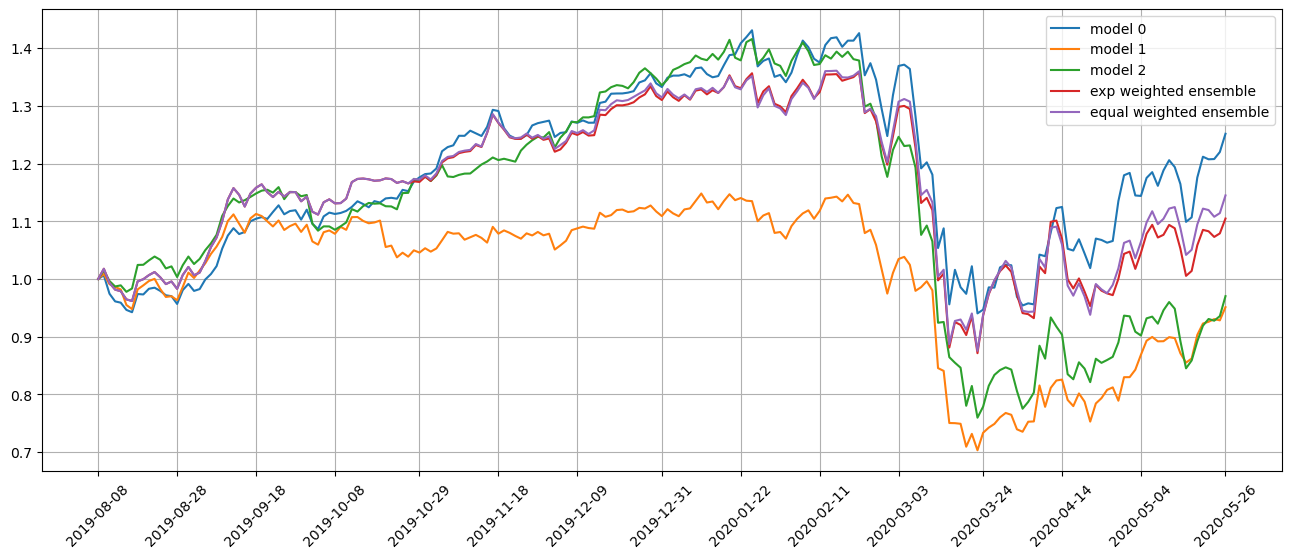

Standardization data are from 2018-10-18 to 2019-08-06
Training data are from 2019-08-07 to 2020-05-21
Testing data are from 2020-04-27 to 2020-06-19
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 11 out of 67 iterations
Epoch 1/500
305/305 [==============================] - 8s 24ms/step - loss: 0.0247 - val_loss: 0.0519 - lr: 0.0050
Epoch 2/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0244 - val_loss: 0.0515 - lr: 0.0050
Epoch 3/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0242 - val_loss: 0.0514 - lr: 0.0050
Epoch 4/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0240 - val_loss: 0.0515 - lr: 0.0050
Epoch 5/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0239 - val_loss: 0.0539 - lr: 0.0050
Epoch 6/500
305/305 [==============================] - 7s 23ms/step - loss: 0.0238 - val_loss: 0.0539 - lr: 0.0050
Epoch 7/500
305

305/305 [==============================] - 8s 25ms/step - loss: 0.0229 - val_loss: 0.0579 - lr: 6.2500e-04
Epoch 21/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0229 - val_loss: 0.0588 - lr: 6.2500e-04
Epoch 22/500
305/305 [==============================] - 8s 25ms/step - loss: 0.0229 - val_loss: 0.0566 - lr: 6.2500e-04
Epoch 22: early stopping
96/96 [==============================] - 2s 24ms/step
Model 0 training loss 0.033627212047576904
11/11 [==============================] - 0s 23ms/step
Model 0 test loss 0.05529581010341644
96/96 [==============================] - 2s 24ms/step
Model 1 training loss 0.031834814697504044
11/11 [==============================] - 0s 23ms/step
Model 1 test loss 0.05586632341146469
96/96 [==============================] - 2s 24ms/step
Model 2 training loss 0.033196110278367996
11/11 [==============================] - 0s 23ms/step
Model 2 test loss 0.0619400255382061
Correlations between old and new weights
0.9746947364916924
0.

position on 2020-05-29 market open will be {'ABT': 0.09697408629972275, 'AXSM': 0.09602664302473475, 'ALL': 0.09719992574478627, 'HAS': 0.09683046405803333, 'VONG': 0.09711948817685533, 'TRI': 0.09784737303705184, 'IYH': 0.09714554239302259, 'MDT': 0.09822690015342865, 'OLN': 0.0922954953126621, 'AMGN': 0.0961225347265803}
Total asset on 2020-05-29 will be 0.9657884529268698
It should be the same as 0.9657884529268779
top_stocks by return weighted ensemble to buy on 2020-05-28 are ['YUM', 'IBB', 'XBI', 'ARWR', 'FBT', 'GFI', 'ALL', 'GDX', 'AXSM', 'VONG']
position on 2020-05-29 market open will be {'AXSM': 0.10815429987177134, 'YUM': 0.1090682306579843, 'XBI': 0.10765322588064463, 'FBT': 0.10869459393457867, 'GDX': 0.10946569550106894, 'ARWR': 0.10640808680994684, 'VONG': 0.10909687393336294, 'IBB': 0.10884459366040578, 'GFI': 0.10986916295581516, 'ALL': 0.10759043418024475}
Total asset on 2020-05-29 will be 1.0848451973858135
It should be the same as 1.0848451973858235
top_stocks by equ

top_stocks by model 2 to buy on 2020-06-02 are ['DGX', 'RWM', 'SRTY', 'TLT', 'TZA', 'SPTL', 'AXON', 'ESPR', 'NG', 'SCO']
position on 2020-06-03 market open will be {'SCO': 0.07946220763394558, 'RWM': 0.09833374181191945, 'ESPR': 0.10181620701031219, 'NG': 0.09506161119930534, 'SRTY': 0.0948411428315327, 'DGX': 0.10297019057965742, 'AXON': 0.10638065289251909, 'TLT': 0.09925871479543633, 'SPTL': 0.09927402782005203, 'TZA': 0.09483788414497006}
Total asset on 2020-06-03 will be 0.9722363807196421
It should be the same as 0.9722363807196501
top_stocks by return weighted ensemble to buy on 2020-06-02 are ['TGTX', 'STM', 'TREE', 'CODX', 'NG', 'KRYS', 'KOLD', 'AXON', 'AXSM', 'SCO']
position on 2020-06-03 market open will be {'CODX': 0.10879805891012218, 'NG': 0.10726633045366762, 'TREE': 0.11390803386244441, 'KRYS': 0.11097348743679275, 'STM': 0.11941898099707085, 'AXON': 0.12003859521296702, 'TGTX': 0.11342221839766761, 'SCO': 0.10782826677913877, 'KOLD': 0.10433708486863714, 'AXSM': 0.1101

top_stocks by model 2 to buy on 2020-06-05 are ['IBM', 'FN', 'IYG', 'AAOI', 'EXEL', 'CMPR', 'TAP', 'ATRC', 'KN', 'NYCB']
position on 2020-06-08 market open will be {'IBM': 0.1004219199425568, 'AAOI': 0.10226176612570609, 'NYCB': 0.10417909895431289, 'IYG': 0.1017791510597009, 'FN': 0.10288260933656732, 'CMPR': 0.10054523272536017, 'KN': 0.10007020431492072, 'ATRC': 0.10554445062813862, 'EXEL': 0.09948716657018122, 'TAP': 0.10058207818049093}
Total asset on 2020-06-08 will be 1.0177536778379277
It should be the same as 1.0177536778379357
top_stocks by return weighted ensemble to buy on 2020-06-05 are ['WERN', 'ROG', 'IBN', 'NYCB', 'FOLD', 'IONS', 'IYG', 'KN', 'ATSG', 'AXSM']
position on 2020-06-08 market open will be {'AXSM': 0.11782880907162488, 'ATSG': 0.11061697027763327, 'WERN': 0.11324560903770425, 'NYCB': 0.11684768050380834, 'IYG': 0.11415588965871389, 'ROG': 0.11135182295571079, 'KN': 0.11223912837707074, 'IBN': 0.11555063162531537, 'IONS': 0.11679637848527287, 'FOLD': 0.1114872

position on 2020-06-11 market open will be {'CVLT': 0.10734829980411356, 'WERN': 0.11575543302639055, 'GEF': 0.10378559709322027, 'NSIT': 0.10714182555996694, 'VIRT': 0.11442914526537239, 'MATX': 0.1036612549059045, 'EXPD': 0.11329980403105207, 'HAE': 0.10897172960289934, 'TDC': 0.11756046571777028, 'CYBR': 0.1098576461934802}
Total asset on 2020-06-11 will be 1.1018112012001597
It should be the same as 1.1018112012001702
top_stocks by equal weighted ensemble to buy on 2020-06-10 are ['WERN', 'EXPD', 'GEF', 'NSIT', 'TDC', 'CYBR', 'VIRT', 'HAE', 'CVLT', 'MATX']
position on 2020-06-11 market open will be {'CVLT': 0.11056535136510645, 'GEF': 0.10689588032776229, 'WERN': 0.11922443250929328, 'NSIT': 0.1103526894282749, 'VIRT': 0.11785839809071562, 'MATX': 0.10676781181009447, 'EXPD': 0.11669521236153704, 'HAE': 0.11223743267842834, 'TDC': 0.12108355905449318, 'CYBR': 0.11314989872862652}
Total asset on 2020-06-11 will be 1.1348306663543237
It should be the same as 1.134830666354332
Testing

top_stocks by model 0 to buy on 2020-06-16 are ['VIRT', 'TREE', 'BIL', 'EGHT', 'BTI', 'BSX', 'INFN', 'ERIC', 'ABM', 'CYBR']
position on 2020-06-17 market open will be {'BSX': 0.12464778571765343, 'ABM': 0.12709120250169947, 'VIRT': 0.12449364044627993, 'EGHT': 0.12556489096203022, 'TREE': 0.12368993805693548, 'ERIC': 0.1263829879977813, 'BTI': 0.1271862259122471, 'BIL': 0.1259731008743181, 'CYBR': 0.12666784805082038, 'INFN': 0.12512479798190396}
Total asset on 2020-06-17 will be 1.2568224185016692
It should be the same as 1.2568224185016694
top_stocks by model 1 to buy on 2020-06-16 are ['VIRT', 'SNN', 'AZPN', 'INFN', 'IHI', 'IQV', 'OMFL', 'VHT', 'CYBR', 'XLV']
position on 2020-06-17 market open will be {'VIRT': 0.09050299309671386, 'AZPN': 0.09037434028535159, 'XLV': 0.09213647460821597, 'SNN': 0.09001307558188378, 'VHT': 0.09197939860632698, 'CYBR': 0.0920835742020552, 'OMFL': 0.09065143159620463, 'IQV': 0.0902141456547947, 'IHI': 0.0908424748514641, 'INFN': 0.0909618249365151}
Tota

top_stocks by model 0 to buy on 2020-06-19 are ['AXSM', 'PFE', 'ENPH', 'KR', 'GDXJ', 'BIL', 'AEM', 'VIRT', 'GDX', 'GFI']
position on 2020-06-22 market open will be {'GDX': 0.13061697893691357, 'AEM': 0.13410593114521846, 'PFE': 0.1257780016156308, 'KR': 0.12697757575230081, 'VIRT': 0.12854736289457264, 'GFI': 0.13630968773537158, 'BIL': 0.12713654216762937, 'GDXJ': 0.13314663854268916, 'ENPH': 0.1270278991867602, 'AXSM': 0.1311300214681218}
Total asset on 2020-06-22 will be 1.300776639445208
It should be the same as 1.3007766394452083
top_stocks by model 1 to buy on 2020-06-19 are ['GFI', 'IEF', 'SIMO', 'CPB', 'ASX', 'GIS', 'KR', 'VIRT', 'HRL', 'SBAC']
position on 2020-06-22 market open will be {'GFI': 0.10091229085234067, 'IEF': 0.09331077660537396, 'HRL': 0.09240913774247761, 'KR': 0.09286471534841127, 'VIRT': 0.09401277503738377, 'CPB': 0.09392341340735672, 'ASX': 0.09071816092227906, 'SIMO': 0.09269330032663275, 'GIS': 0.0919968918113208, 'SBAC': 0.0957957808498025}
Total asset on 

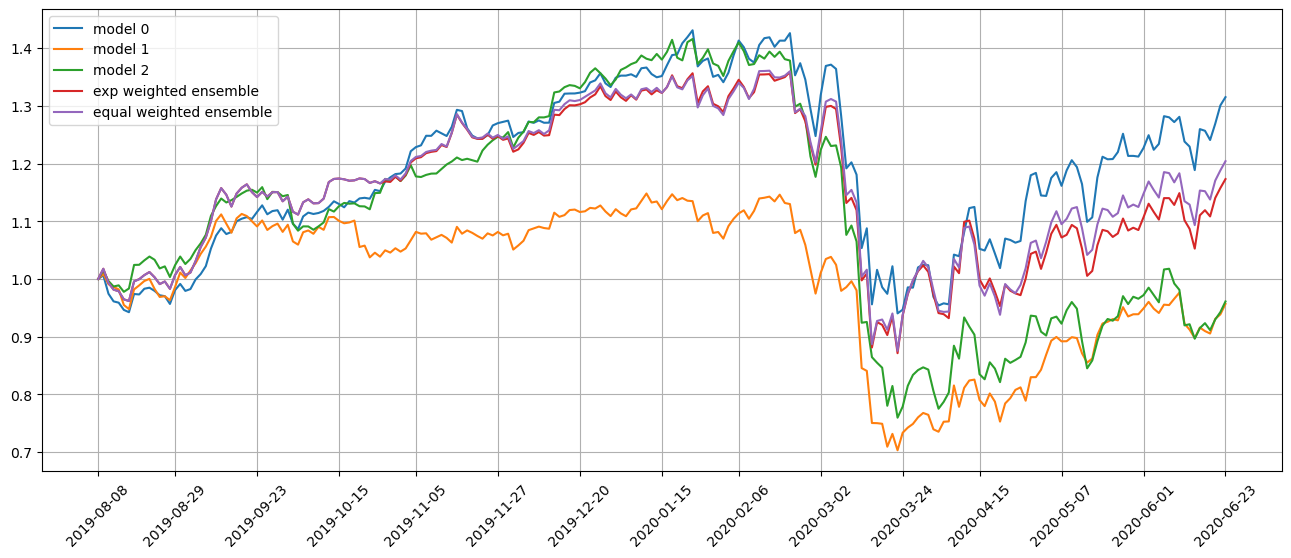

Standardization data are from 2018-11-15 to 2019-09-04
Training data are from 2019-09-05 to 2020-06-19
Testing data are from 2020-05-26 to 2020-07-20
Training data have shape (389512, 20, 28), (389512,)
Testing data have shape (43040, 20, 28), (43040,)
Running iteration 12 out of 67 iterations
Epoch 1/500
 13/305 [>.............................] - ETA: 7s - loss: 0.0279

KeyboardInterrupt: 

In [18]:
# Retrain all the rest
# %run C:\Projects\Stock_price_prediction\Experiments\Transformer_Class.ipynb
print(f'Running {num_iters} iterations; first iteration already completed.')
first_run = False

for num_iter in range(1, num_iters):
    # Find train and test data
    ftd += seq_length
    ltd += seq_length
    data_train, x_train, y_train, data_test, x_test, y_test, ret_d_train, ret_d_test, sector_train, sector_test = prep_train_test_data(data, seq_length, ftd, ltd, all_days)
    print(f'Running iteration {num_iter+1} out of {num_iters} iterations')
    Transformer_model.retrain_model(x_train, y_train, ret_d_train, sector_train) 
    Transformer_model.evaluate_model(x_train, y_train, ret_d_train, sector_train, x_test, y_test, ret_d_test, sector_test, batch_size)

    if save:
        for i in range(model_params['num_models']):
            Transformer_model.model_dict[i].save(f"models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")

    gc.collect()
    
    # Check how much the weights are trained
    print("Correlations between old and new weights")
    for i in range(num_of_models):
        new_weights[i] = Transformer_model.model_dict[i].get_weights()
        print(np.corrcoef(old_weights[i][0][0], new_weights[i][0][0])[0, 1])
        x = old_weights[i][-1]
        y = new_weights[i][-1]
        print(np.corrcoef(x.reshape(40, ), y.reshape(40, ))[0, 1])
    old_weights = new_weights.copy()
    
    total_asset_dict, total_dict, position_dict_all, return_dict = simulate(ftd, ltd, total_dict, first_run, num_stocks, total_asset_dict, 
                                                                            position_dict_all, return_dict)

In [ ]:
import json

with open('total_asset_dict.json', 'w') as f:
    json.dump(total_asset_dict, f)
    
# with open('total_asset_dict.json', 'r') as fr:
#     test = json.load(fr)

In [ ]:
last_simul_day = "2024-12-03"
rfr = list(data[data['datadate'] <= last_simul_day][['datadate', 'TBill1y']].drop_duplicates(subset=['datadate'])['TBill1y'])
rfr = rfr[-(len(total_asset_dict[0])-1):]

def calculate_SR(total_asset, rfr):
    '''
    Calculates the Sharpe Ratio of the simulated strategy
    Inputs:
        total_asset: list of total assets on each day
        rfr: list of risk-free rates on the same days as in total_asset
    Output:
        SR: Sharpe Ratio
    '''
    
    daily_ret = [(total_asset[i] - total_asset[i-1]) / total_asset[i-1] for i in range(1, len(total_asset))]
    assert len(daily_ret) == len(rfr)
    excess_ret = [daily_ret[i] - rfr[i] for i in range(len(rfr))]
    SR = np.mean(excess_ret) / np.std(excess_ret) * np.sqrt(252)
    
    return SR
for key, item in total_asset_dict.items():
    SR = calculate_SR(item, rfr)
    print(f'SR for model {key} is {SR}')